In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 9.0)

## Q1 Performance analysis of hedge fund returns using linear regression.

### (a) Download and import the following data into your Jupyter notebook:

* **Monthly data of the Fama-French 5 Factor model** from Ken French’s data library. The Fama-French 5 Factor model is described as:

-----------
Monthly Returns:  July 1963 - August 2020
 	 	 
Annual Returns:	  1964 - 2019
 	 	 
Construction:	 	

The Fama/French 5 factors (2x3) are constructed using the 6 value-weight portfolios formed on size and book-to-market, the 6 value-weight portfolios formed on size and operating profitability, and the 6 value-weight portfolios formed on size and investment. (See the description of the 6 size/book-to-market, size/operating profitability, size/investment portfolios.)
 	 	 
**SMB (Small Minus Big)** is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios,
 	 	 
SMB(B/M) = 1/3 (Small Value + Small Neutral + Small Growth) - 1/3 (Big Value + Big Neutral + Big Growth).

SMB(OP) = 1/3 (Small Robust + Small Neutral + Small Weak) - 1/3 (Big Robust + Big Neutral + Big Weak).

SMB(INV) = 1/3 (Small Conservative + Small Neutral + Small Aggressive) - 1/3 (Big Conservative + Big Neutral + Big Aggressive).

SMB = 1/3 ( SMB(B/M) + SMB(OP) + SMB(INV) ).
 
 	 	 
**HML (High Minus Low)** is the average return on the two value portfolios minus the average return on the two growth portfolios,
 	 	 
HML = 1/2 (Small Value + Big Value) - 1/2 (Small Growth + Big Growth).	 


**RMW (Robust Minus Weak)** is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,
 	 	 
RMW = 1/2 (Small Robust + Big Robust) - 1/2 (Small Weak + Big Weak).	 
 	 	 
**CMA (Conservative Minus Aggressive)** is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,
 	 	 
CMA = 1/2 (Small Conservative + Big Conservative) - 1/2 (Small Aggressive + Big Aggressive).

Rm-Rf, the excess return on the market, value-weight return of all CRSP firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month t, good shares and price data at the beginning of t, and good return data for t minus the one-month Treasury bill rate (from Ibbotson Associates).
 	 	 
See Fama and French, 1993, "Common Risk Factors in the Returns on Stocks and Bonds," Journal of Financial Economics, and Fama and French, 2014, "A Five-Factor Asset Pricing Model" for a complete description of the factor returns.
 	 	 
Stocks:	 	

Rm-Rf includes all NYSE, AMEX, and NASDAQ firms. SMB, HML, RMW, and CMA for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have market equity data for December of t-1 and June of t, (positive) book equity data for t-1 (for SMB, HML, and RMW), non-missing revenues and at least one of the following: cost of goods sold, selling, general and administrative expenses, or interest expense for t-1 (for SMB and RMW), and total assets data for t-2 and t-1 (for SMB and CMA).

-----------

* **Monthly returns from Yahoo Finance for the AQR Equity Market Neutral Fund Class I (Ticker: QMNIX)**. Make sure you get the series that is adjusted for both dividends and splits (i.e. the series marked “Adj Close” on Yahoo Finance).

**Note**: 
- Yahoo Finance will provide you with prices. Hence you will have to compute returns yourself.
- Use the longest time period you can find where all data series are available.

In [2]:
# Monthly data of the Fama-French 5 Factor model from Ken French’s data library:
mypath = r'~\Desktop\DS\HW4\FF_Data\F-F_Research_Data_5_Factors_2x3.CSV'
kenFrench_df = pd.read_csv(mypath, skiprows=3, skipfooter=749-690, engine='python')
kenFrench_df = kenFrench_df.rename(columns={'Unnamed: 0':'Date'}).set_index('Date')
kenFrench_df.index = pd.to_datetime(kenFrench_df.index, format="%Y%m")
kenFrench_df.rename(columns={'Mkt-RF':'RM'}, inplace=True)
# kenFrench_df.drop(columns = 'RF', inplace=True)
kenFrench_df

,RM,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.47,-0.83,0.66,-1.15,0.27
1963-08-01,5.07,-0.79,1.67,0.40,-0.40,0.25
1963-09-01,-1.57,-0.48,0.18,-0.76,0.24,0.27
1963-10-01,2.53,-1.29,-0.10,2.75,-2.24,0.29
1963-11-01,-0.85,-0.84,1.71,-0.45,2.22,0.27
...,...,...,...,...,...,...
2020-04-01,13.65,2.79,-1.35,2.51,-1.03,0.00
2020-05-01,5.58,1.92,-4.95,0.71,-3.28,0.01
2020-06-01,2.46,1.94,-2.22,0.03,0.34,0.01


In [3]:
start_date_factors = kenFrench_df.index[0]
end_date_factors = kenFrench_df.index[-1]

In [4]:
# web scraping
import pandas_datareader.data as web
df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '1963-07-01', end = '2020-08-01')[0]
df_factors.rename(columns={'Mkt-RF':'RM'}, inplace=True)
df_factors.drop(columns = 'RF', inplace=True)
df_factors

,RM,SMB,HML,RMW,CMA
Date,,,,,
1963-07,-0.39,-0.47,-0.83,0.66,-1.15
1963-08,5.07,-0.79,1.67,0.40,-0.40
1963-09,-1.57,-0.48,0.18,-0.76,0.24
1963-10,2.53,-1.29,-0.10,2.75,-2.24
1963-11,-0.85,-0.84,1.71,-0.45,2.22
...,...,...,...,...,...
2020-04,13.65,2.79,-1.35,2.51,-1.03
2020-05,5.58,1.92,-4.95,0.71,-3.28
2020-06,2.46,1.94,-2.22,0.03,0.34


In [5]:
# web scraping
# Monthly returns from Yahoo Finance for the AQR Equity Market Neutral Fund Class I 
# (Ticker: QMNIX)

import yfinance as yf
data = yf.download('QMNIX', period = 'max', progress=False, interval='1mo')
QMNIX = data[['Adj Close']].dropna()

def price2ret(prices, retType='simple'):
    ''' Convert price to return
    Args
    ----------
    prices: pd.DataFrame
    retype: str
        arithmetic return, p2/p1 - 1, same as pct_change()
        logarithmetic return, log(p2/p1)
    
    Returns
    ----------
    return: pd.DataFrame
    
    '''
    price_df = prices.copy()
    if retType == 'simple':
        ret = (price_df/price_df.shift(1))-1
    else: 
        ret = np.log(price_df/price_df.shift(1))
    price_df['Return'] = ret
    return price_df.dropna()[['Return']]

QMNIX_return_df = price2ret(QMNIX)
QMNIX_return_df

,Return
Date,
2014-11-01,0.025666
2014-12-01,-0.036574
2015-01-01,0.156134
2015-02-01,-0.007767
2015-03-01,0.004892
...,...
2020-06-01,0.020177
2020-07-01,-0.018541
2020-08-01,-0.012594


In [6]:
start_date_hf = QMNIX_return_df.index[0]
end_date_hf = QMNIX_return_df.index[-1]

### (b) Create scatter plots and compute summary statistics of all data series (mean, std, skew, kurtosis, max, min, correlation matrix). Discuss your conclusions and any noteworthy results after visualizing and exploring the data. 

##### Summary Statistics of Fama-French Data:

In [7]:
kenFrench_df.agg(['mean','std','skew','kurtosis','max','min'])

,RM,SMB,HML,RMW,CMA,RF
mean,0.554636,0.207595,0.254942,0.260000,0.259534,0.374636
std,4.451114,3.014687,2.872401,2.167372,1.992396,0.264817
skew,-0.536644,0.337433,0.009682,-0.342250,0.313613,0.652878
kurtosis,1.935704,3.069454,2.434476,12.465048,1.623665,0.720586
max,16.100000,18.050000,12.600000,13.380000,9.560000,1.350000
min,-23.240000,-14.860000,-14.110000,-18.480000,-6.860000,0.000000


In [8]:
kenFrench_df.corr()

,RM,SMB,HML,RMW,CMA,RF
RM,1.000000,0.285862,-0.226222,-0.201378,-0.380483,-0.089169
SMB,0.285862,1.000000,-0.038588,-0.336787,-0.104220,-0.031042
HML,-0.226222,-0.038588,1.000000,0.080233,0.684600,0.102513
RMW,-0.201378,-0.336787,0.080233,1.000000,-0.025316,0.002501
CMA,-0.380483,-0.104220,0.684600,-0.025316,1.000000,0.081936
RF,-0.089169,-0.031042,0.102513,0.002501,0.081936,1.000000


Text(0.5, 1.0, 'RF')

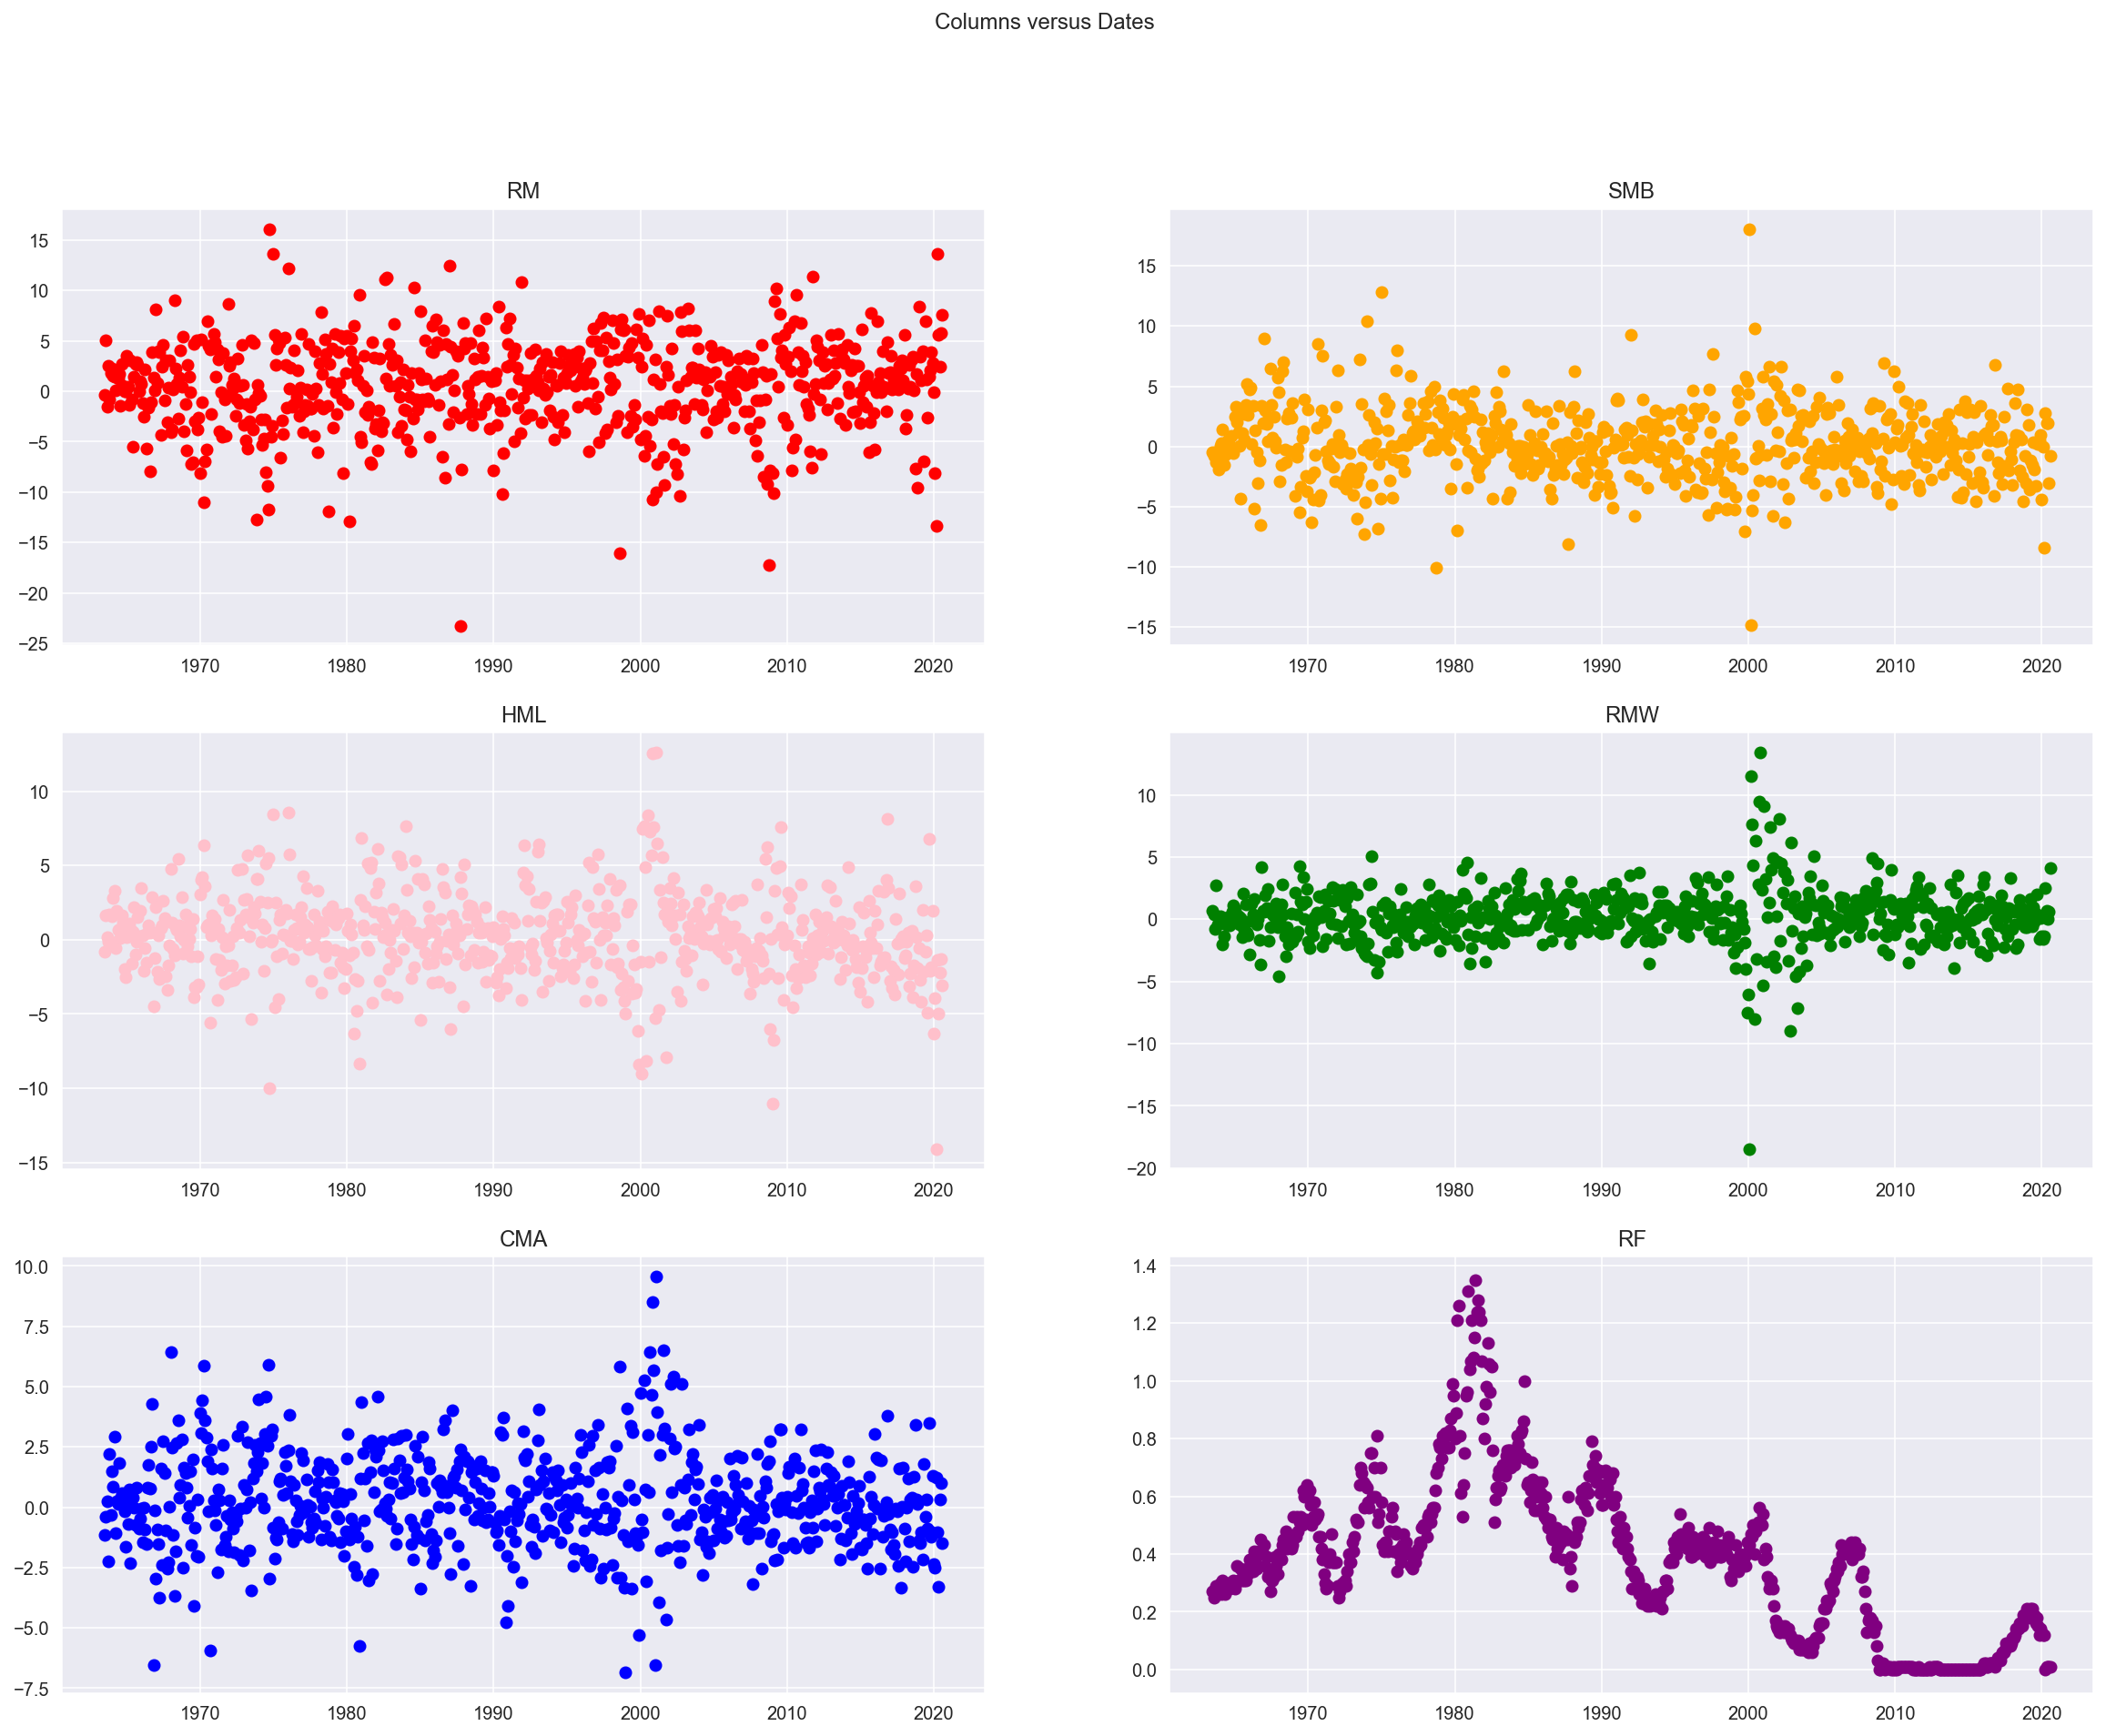

In [9]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# kenFrench_df 
# time series of each column
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,15))
fig.suptitle('Columns versus Dates')
x = kenFrench_df.index
ax1.scatter(x, kenFrench_df['RM'], color='red')
ax1.set_title('RM')
ax2.scatter(x, kenFrench_df['SMB'], color='orange')
ax2.set_title('SMB')
ax3.scatter(x, kenFrench_df['HML'], color='pink')
ax3.set_title('HML')
ax4.scatter(x, kenFrench_df['RMW'], color='green')
ax4.set_title('RMW')
ax5.scatter(x, kenFrench_df['CMA'], color='blue')
ax5.set_title('CMA')
ax6.scatter(x, kenFrench_df['RF'], color='purple')
ax6.set_title('RF')

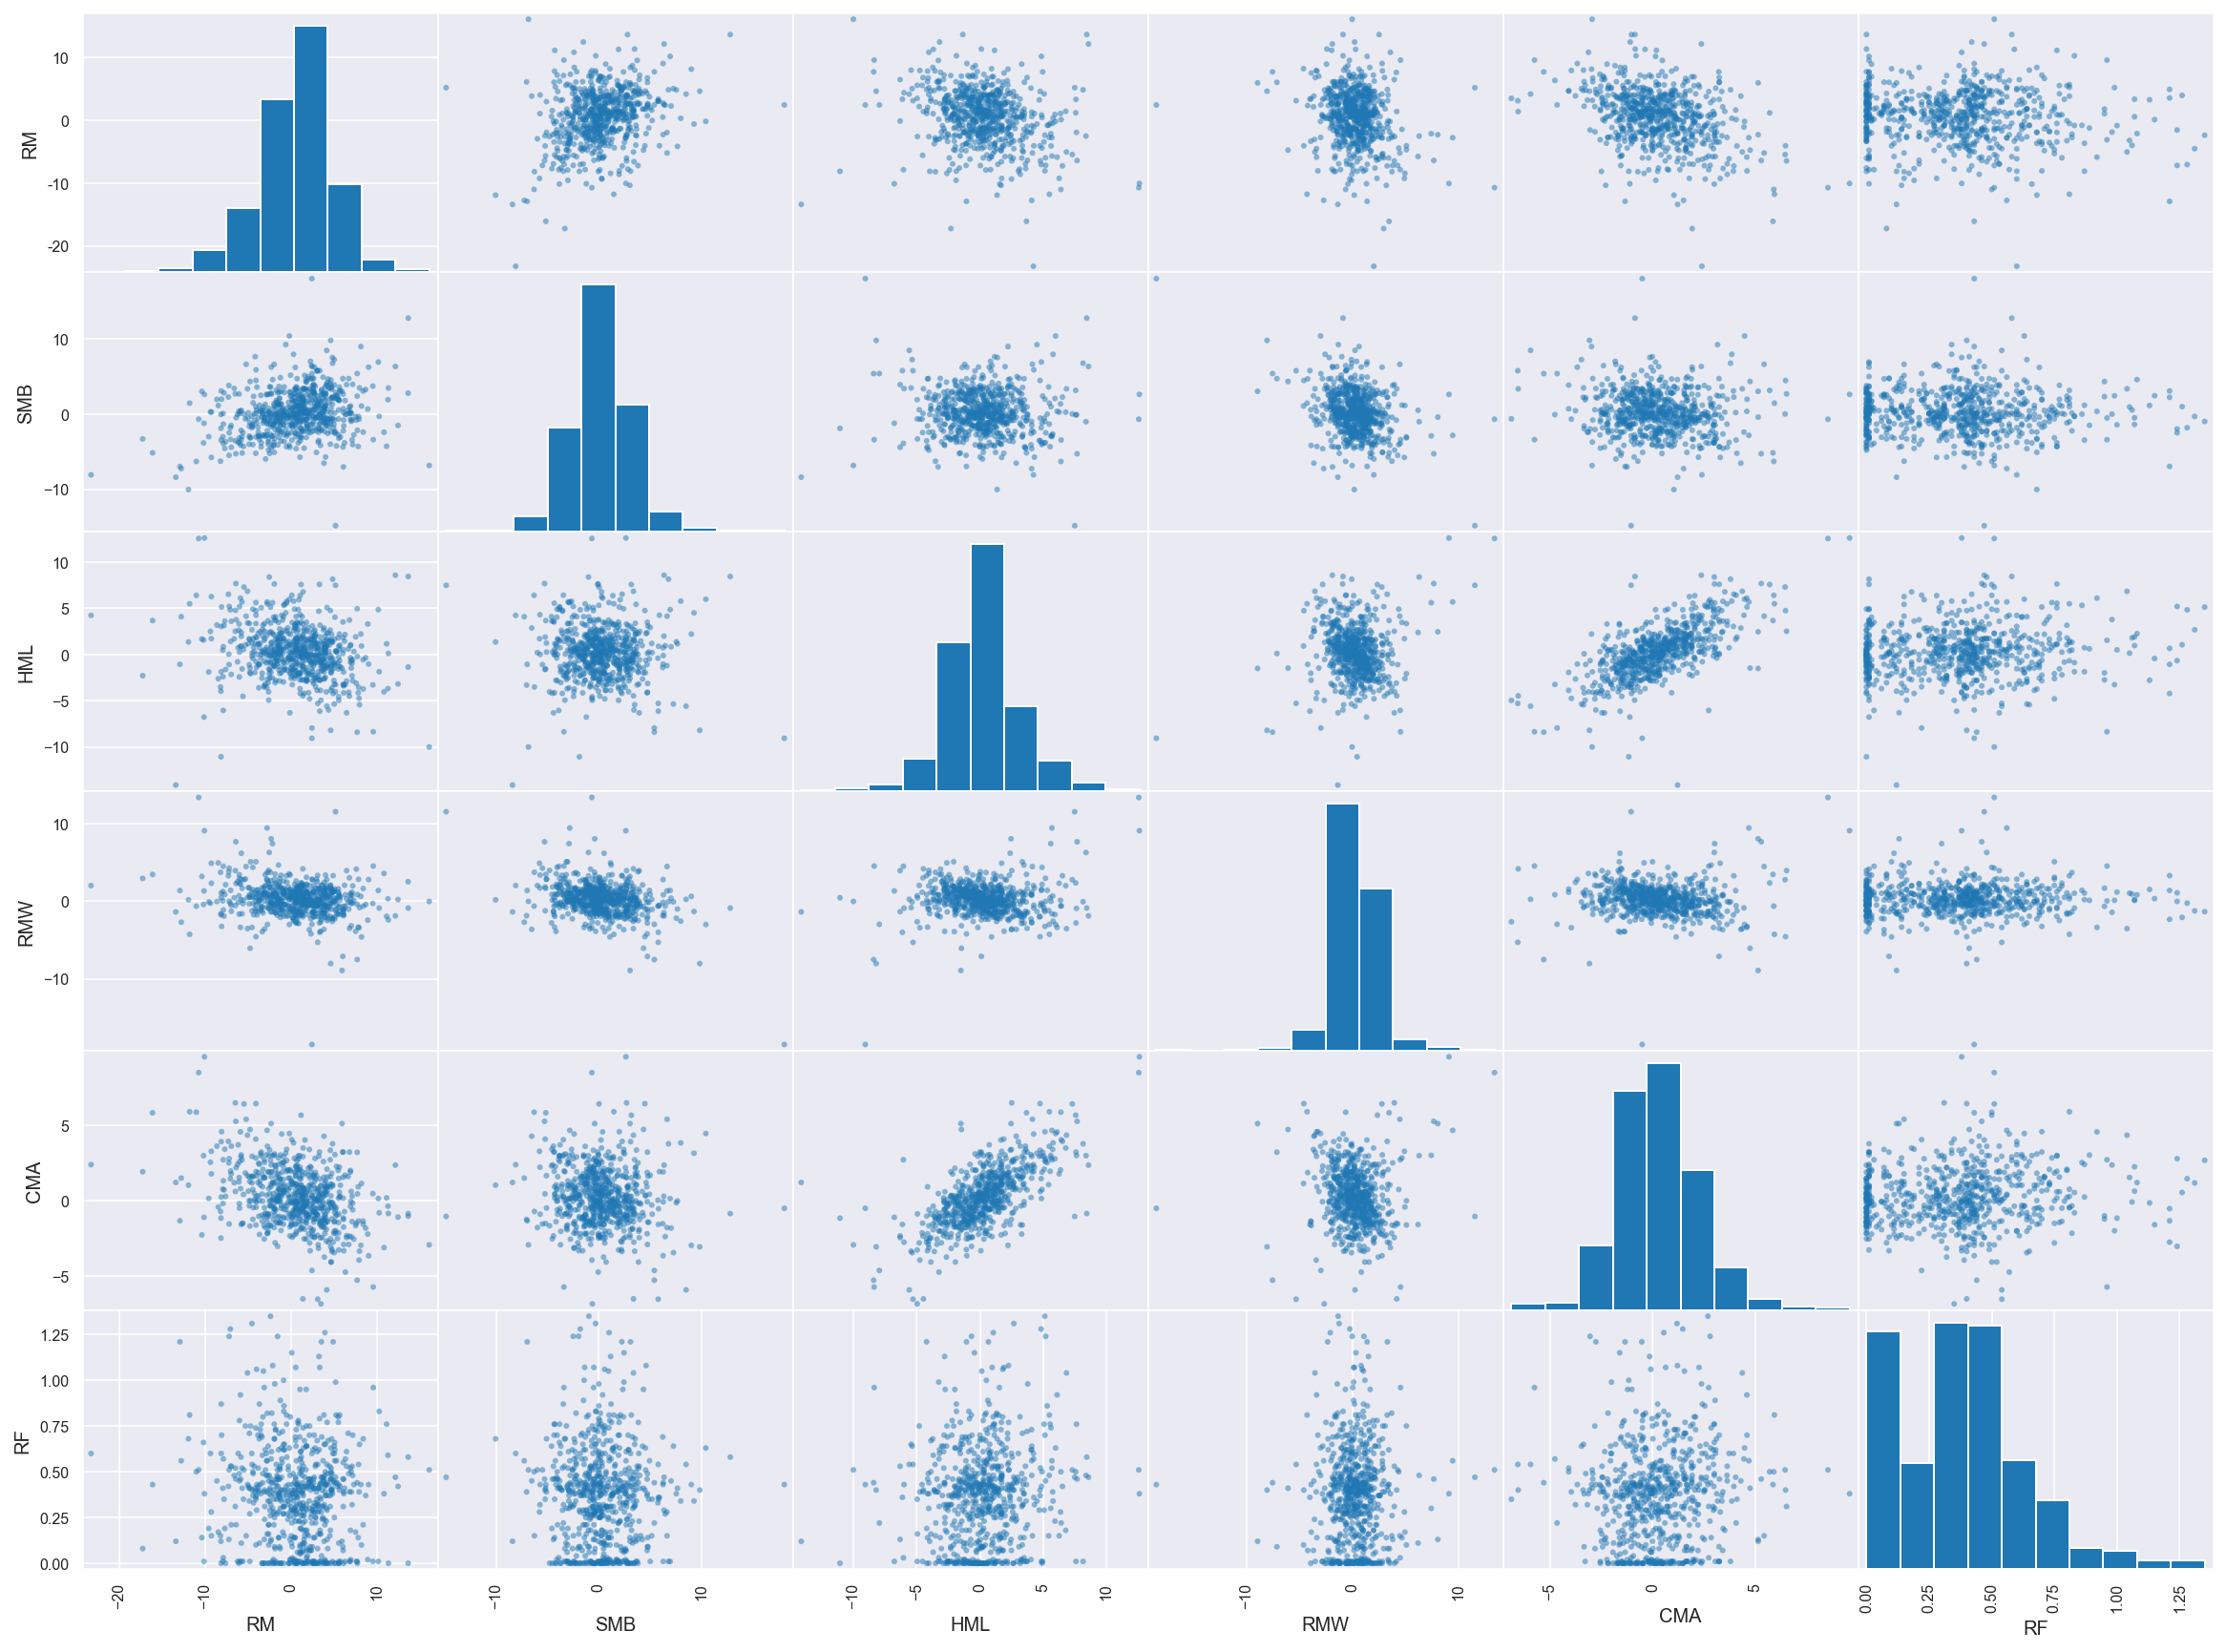

In [10]:
# kenFrench_df 
# among columns
from pandas.plotting import scatter_matrix
import os
attributes = kenFrench_df.columns
scatter_matrix(kenFrench_df[attributes], figsize=(20,15))
IMAGES_PATH = r'~\Desktop\DS\HW4'
plt.savefig("scatter_matrix_plot")

##### Summary Statistics of Hedge Fund QMNIX Monthly Return Data:

In [11]:
QMNIX_return_df.agg(['mean','std','skew','kurtosis','max','min'])

,Return
mean,0.000054
std,0.029320
skew,2.129014
kurtosis,10.618758
max,0.156134
min,-0.057075


Text(0, 0.5, 'Return')

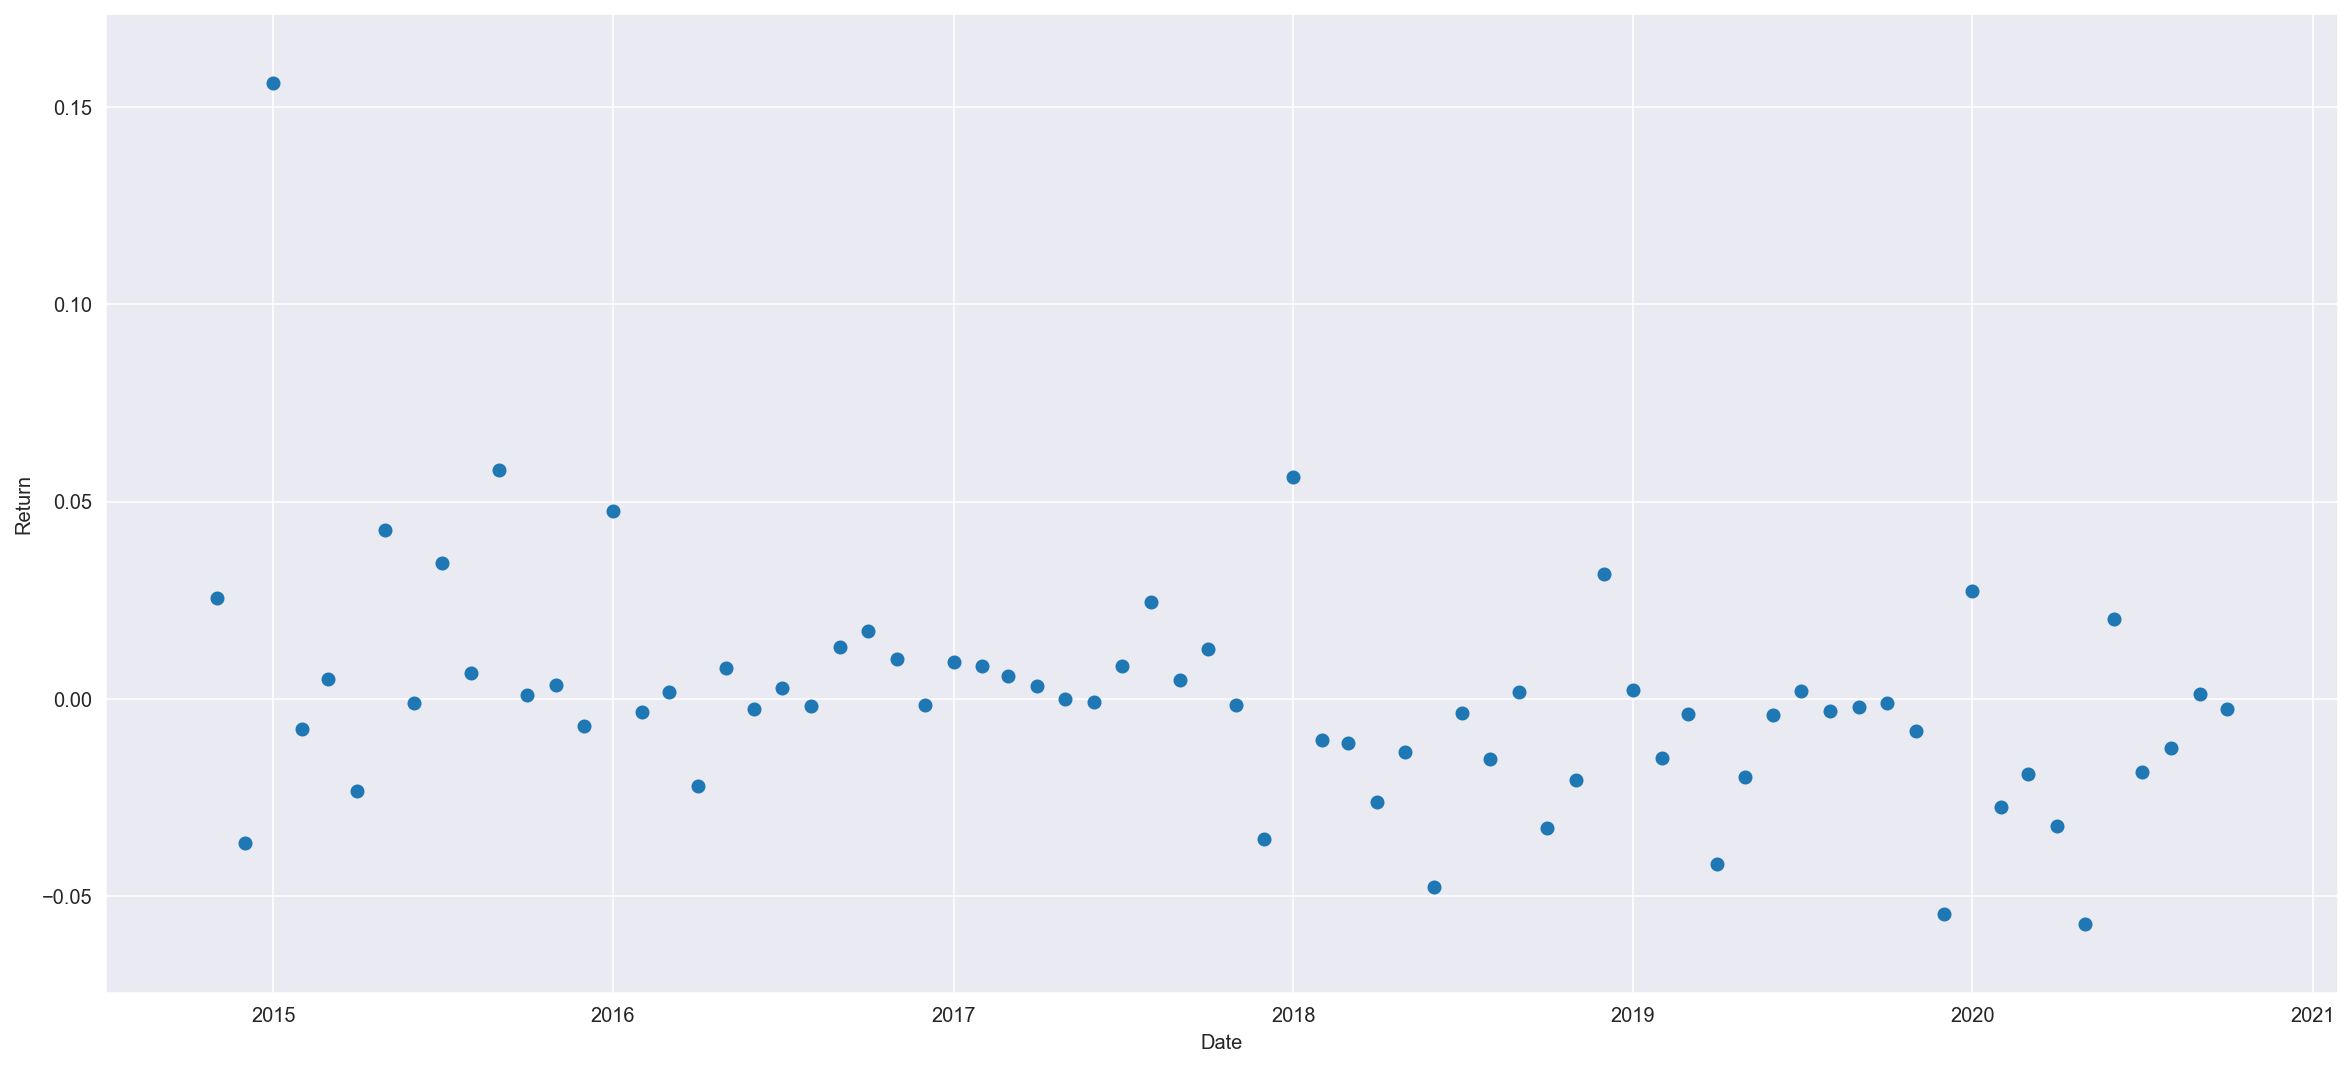

In [12]:
plt.scatter(QMNIX_return_df.index, QMNIX_return_df['Return'])
plt.xlabel('Date')
plt.ylabel('Return')

##### Relationship between Fama-French Data and Hedge Fund Monthly Returns:

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-11
end_date:  2020-08


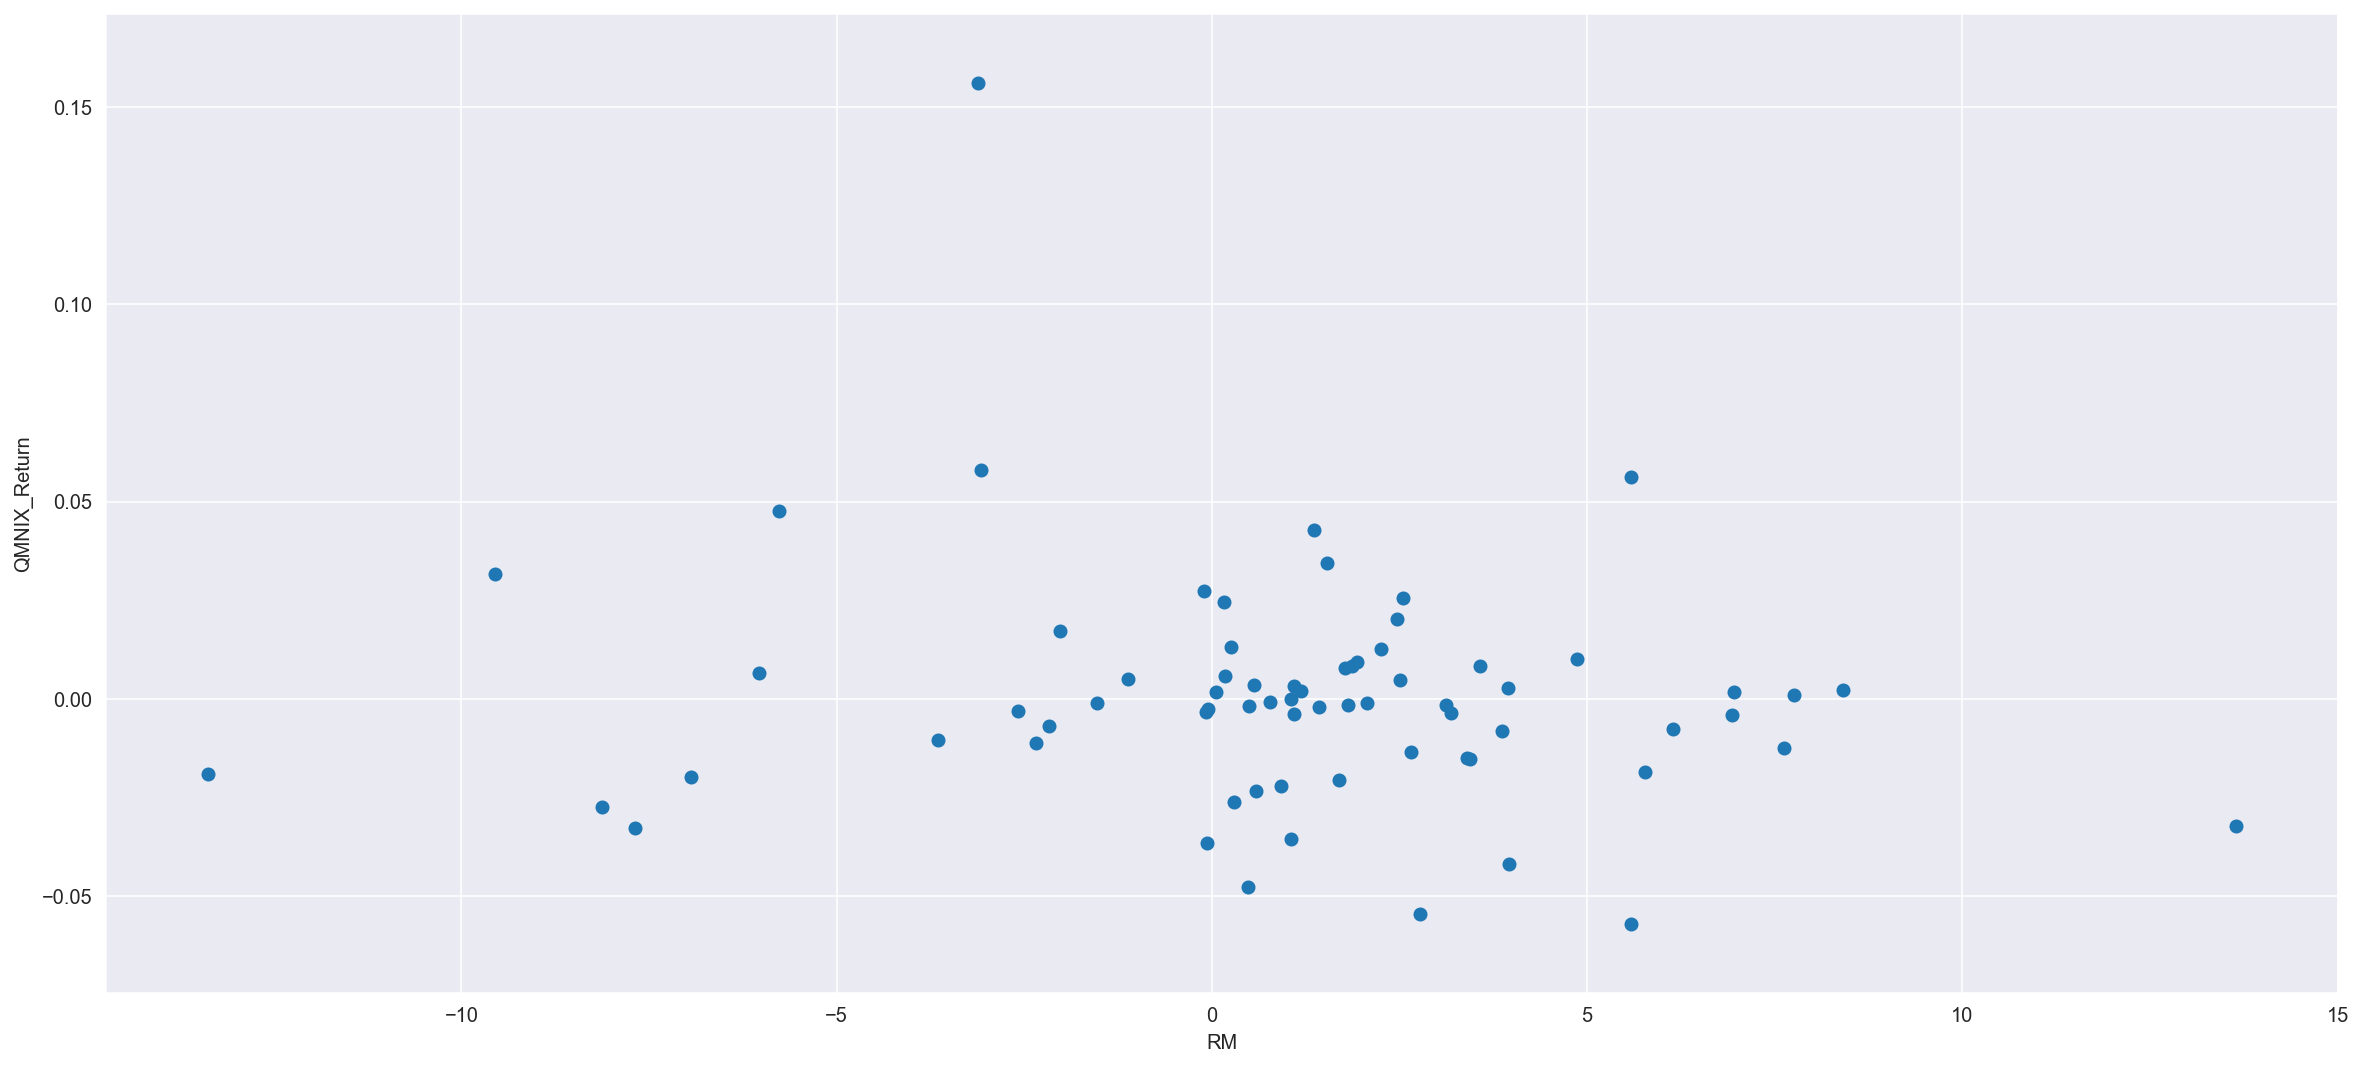

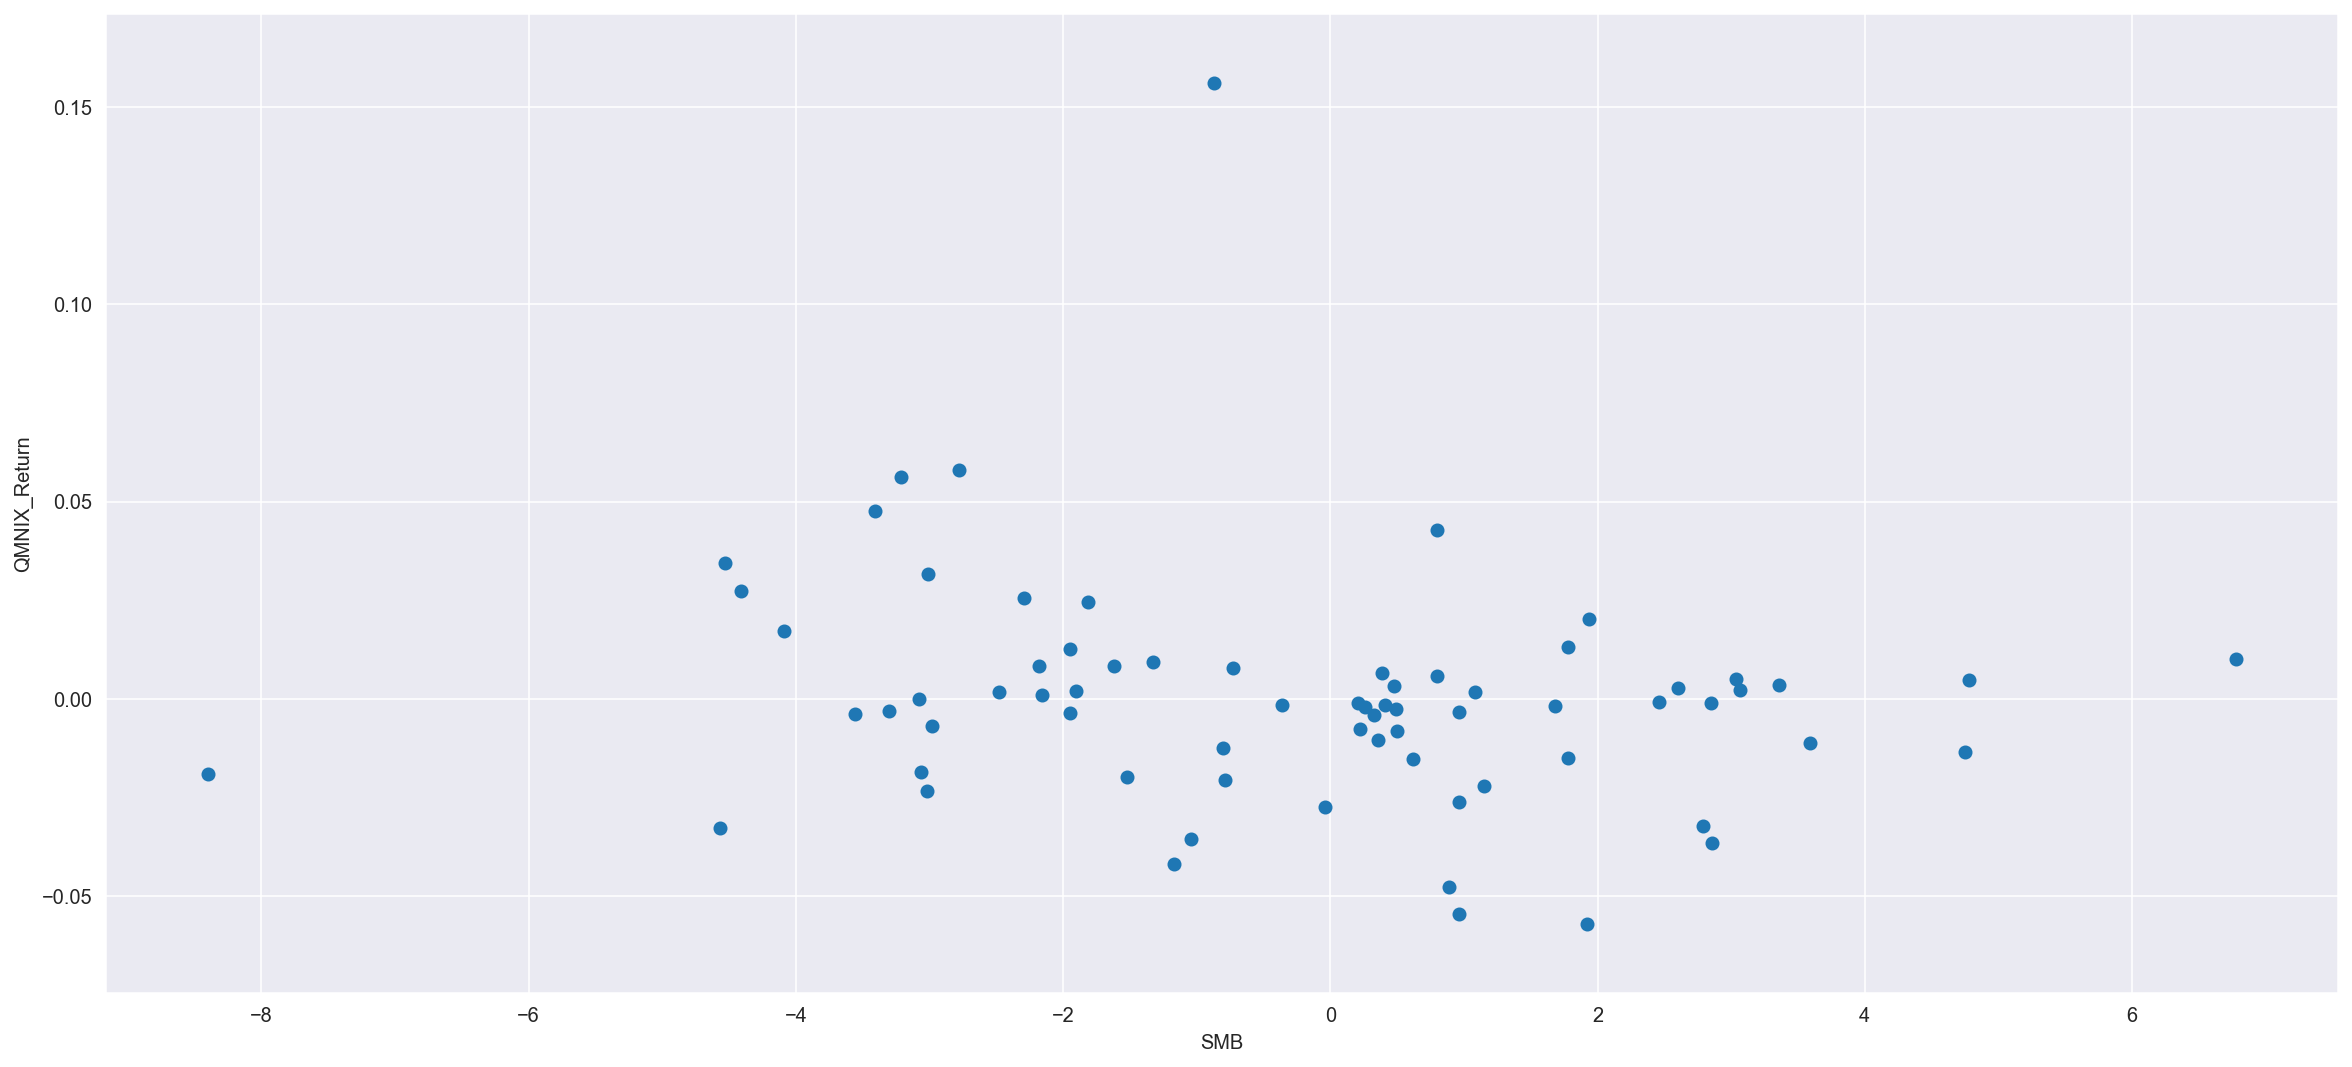

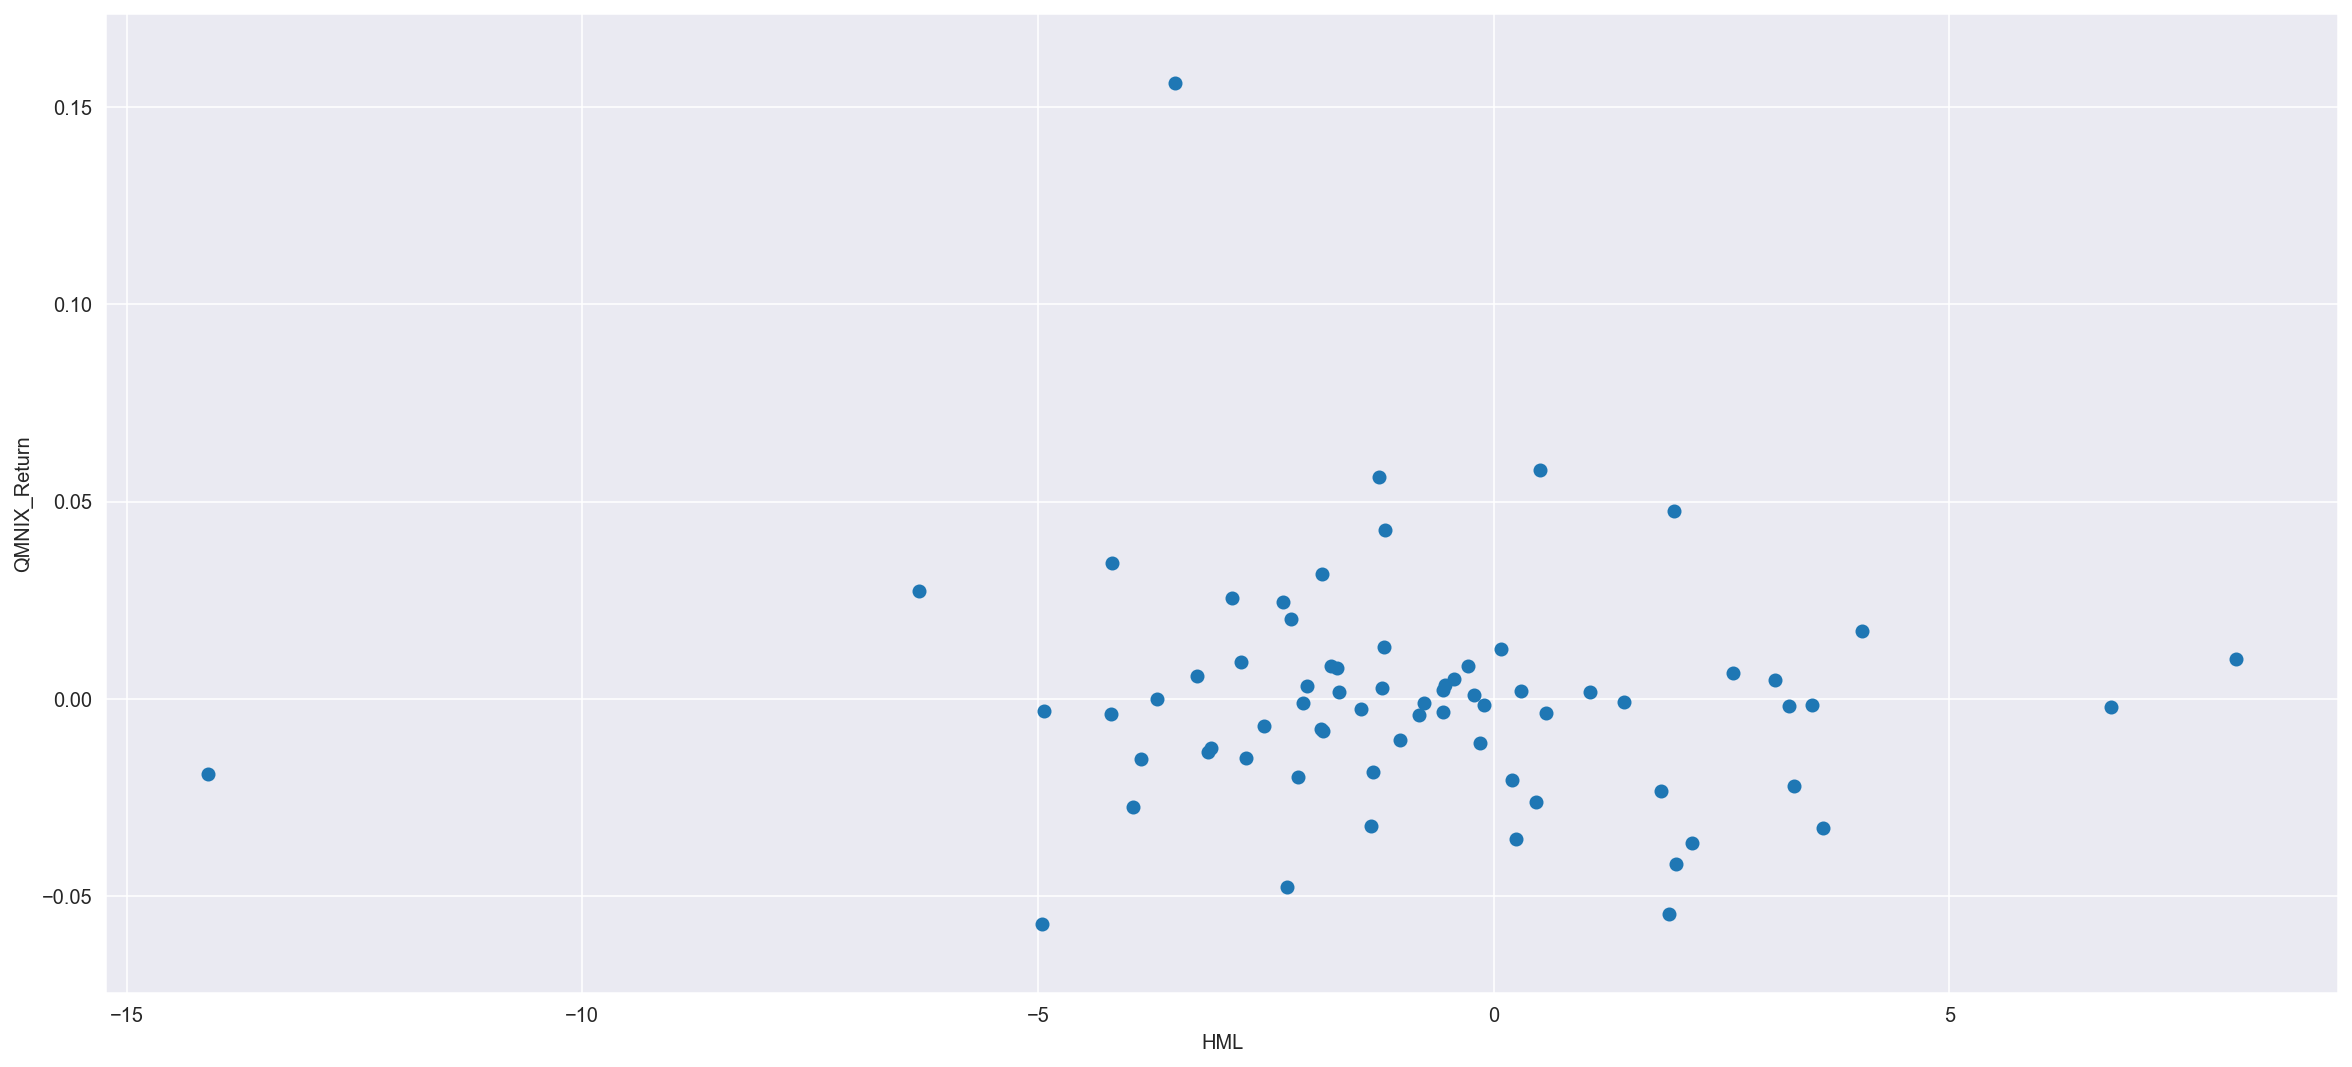

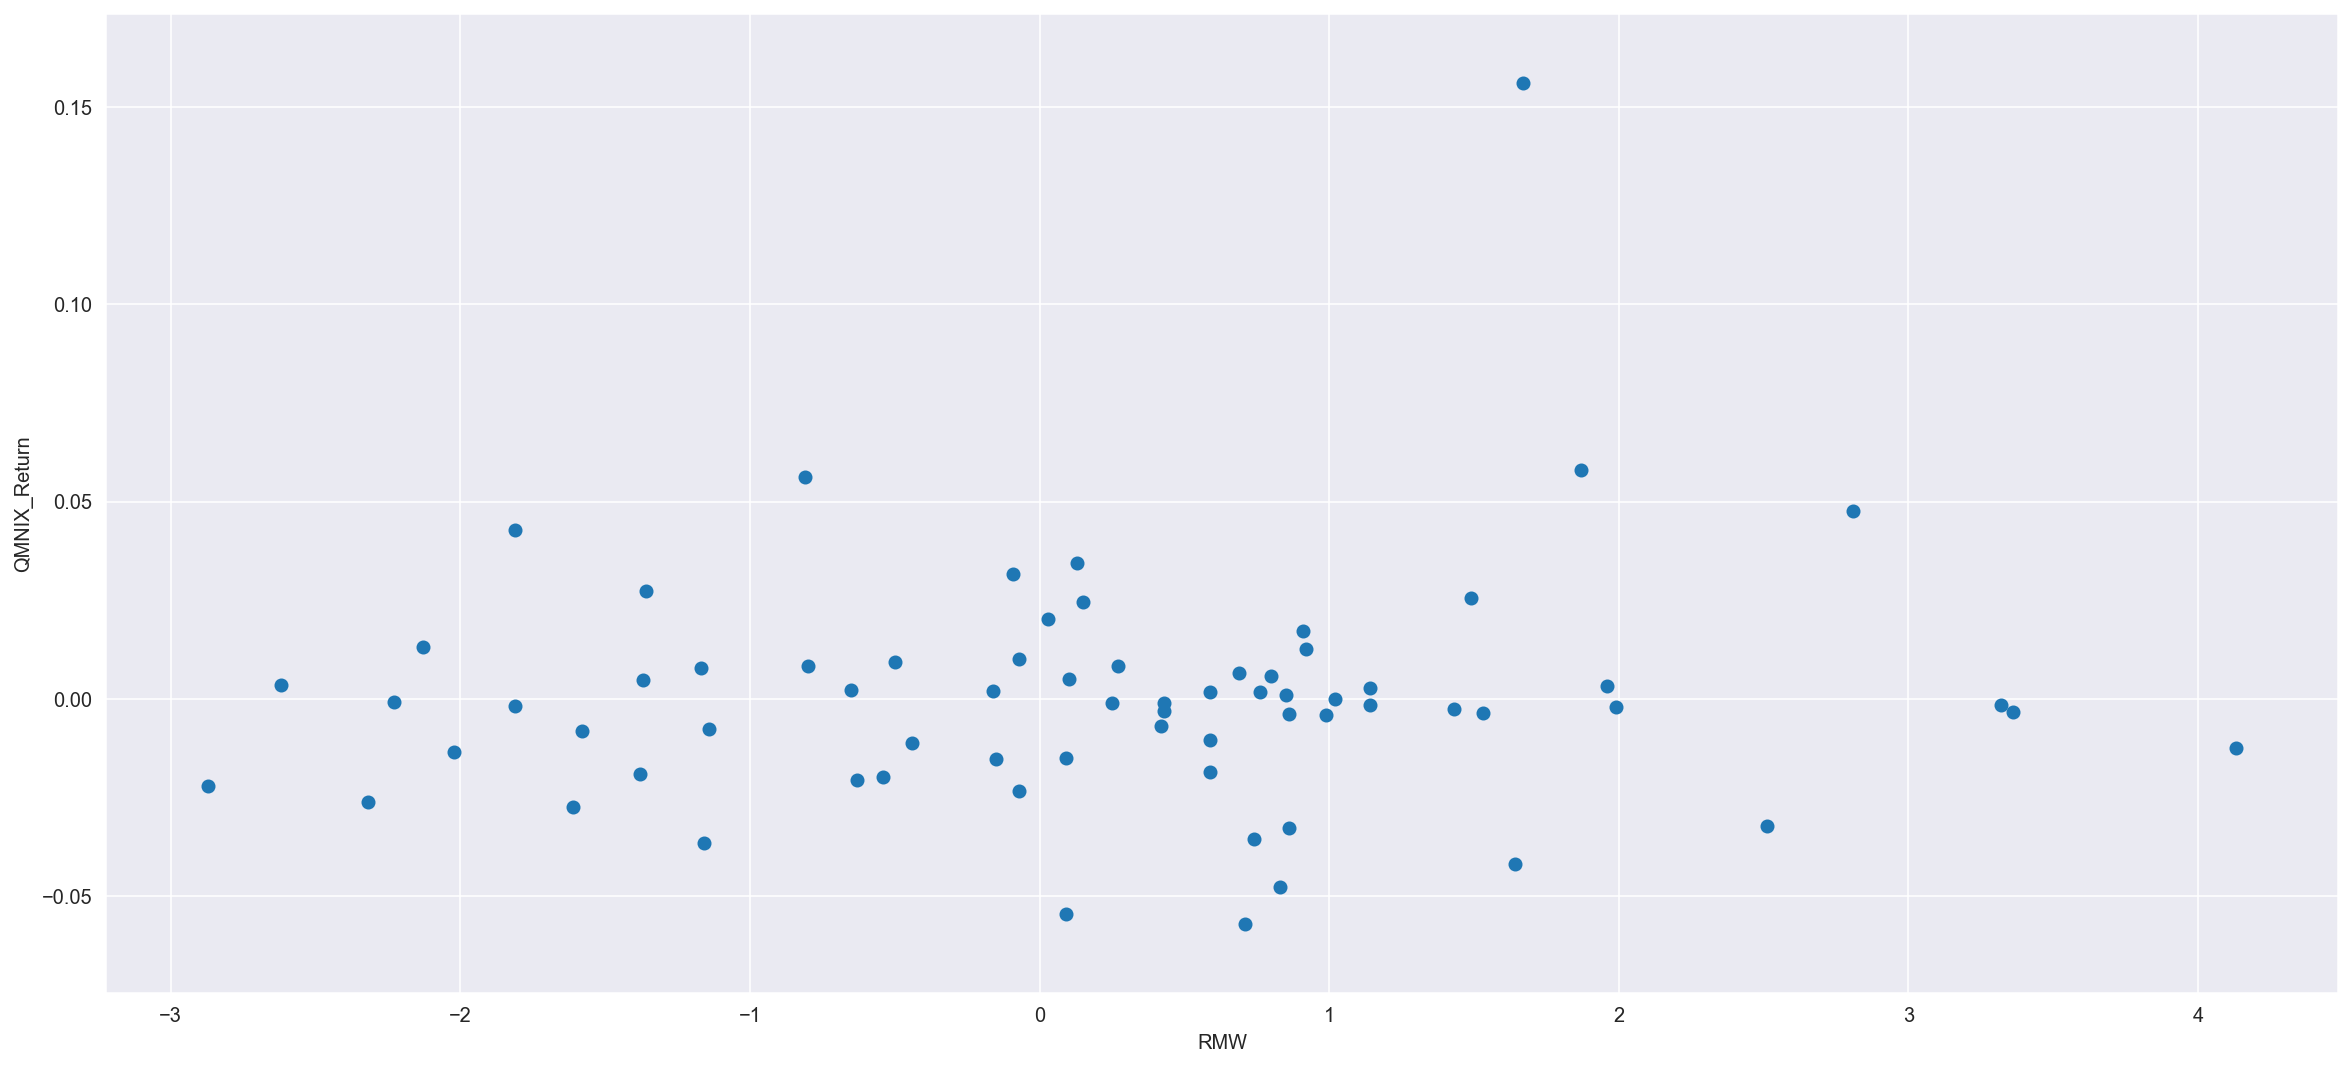

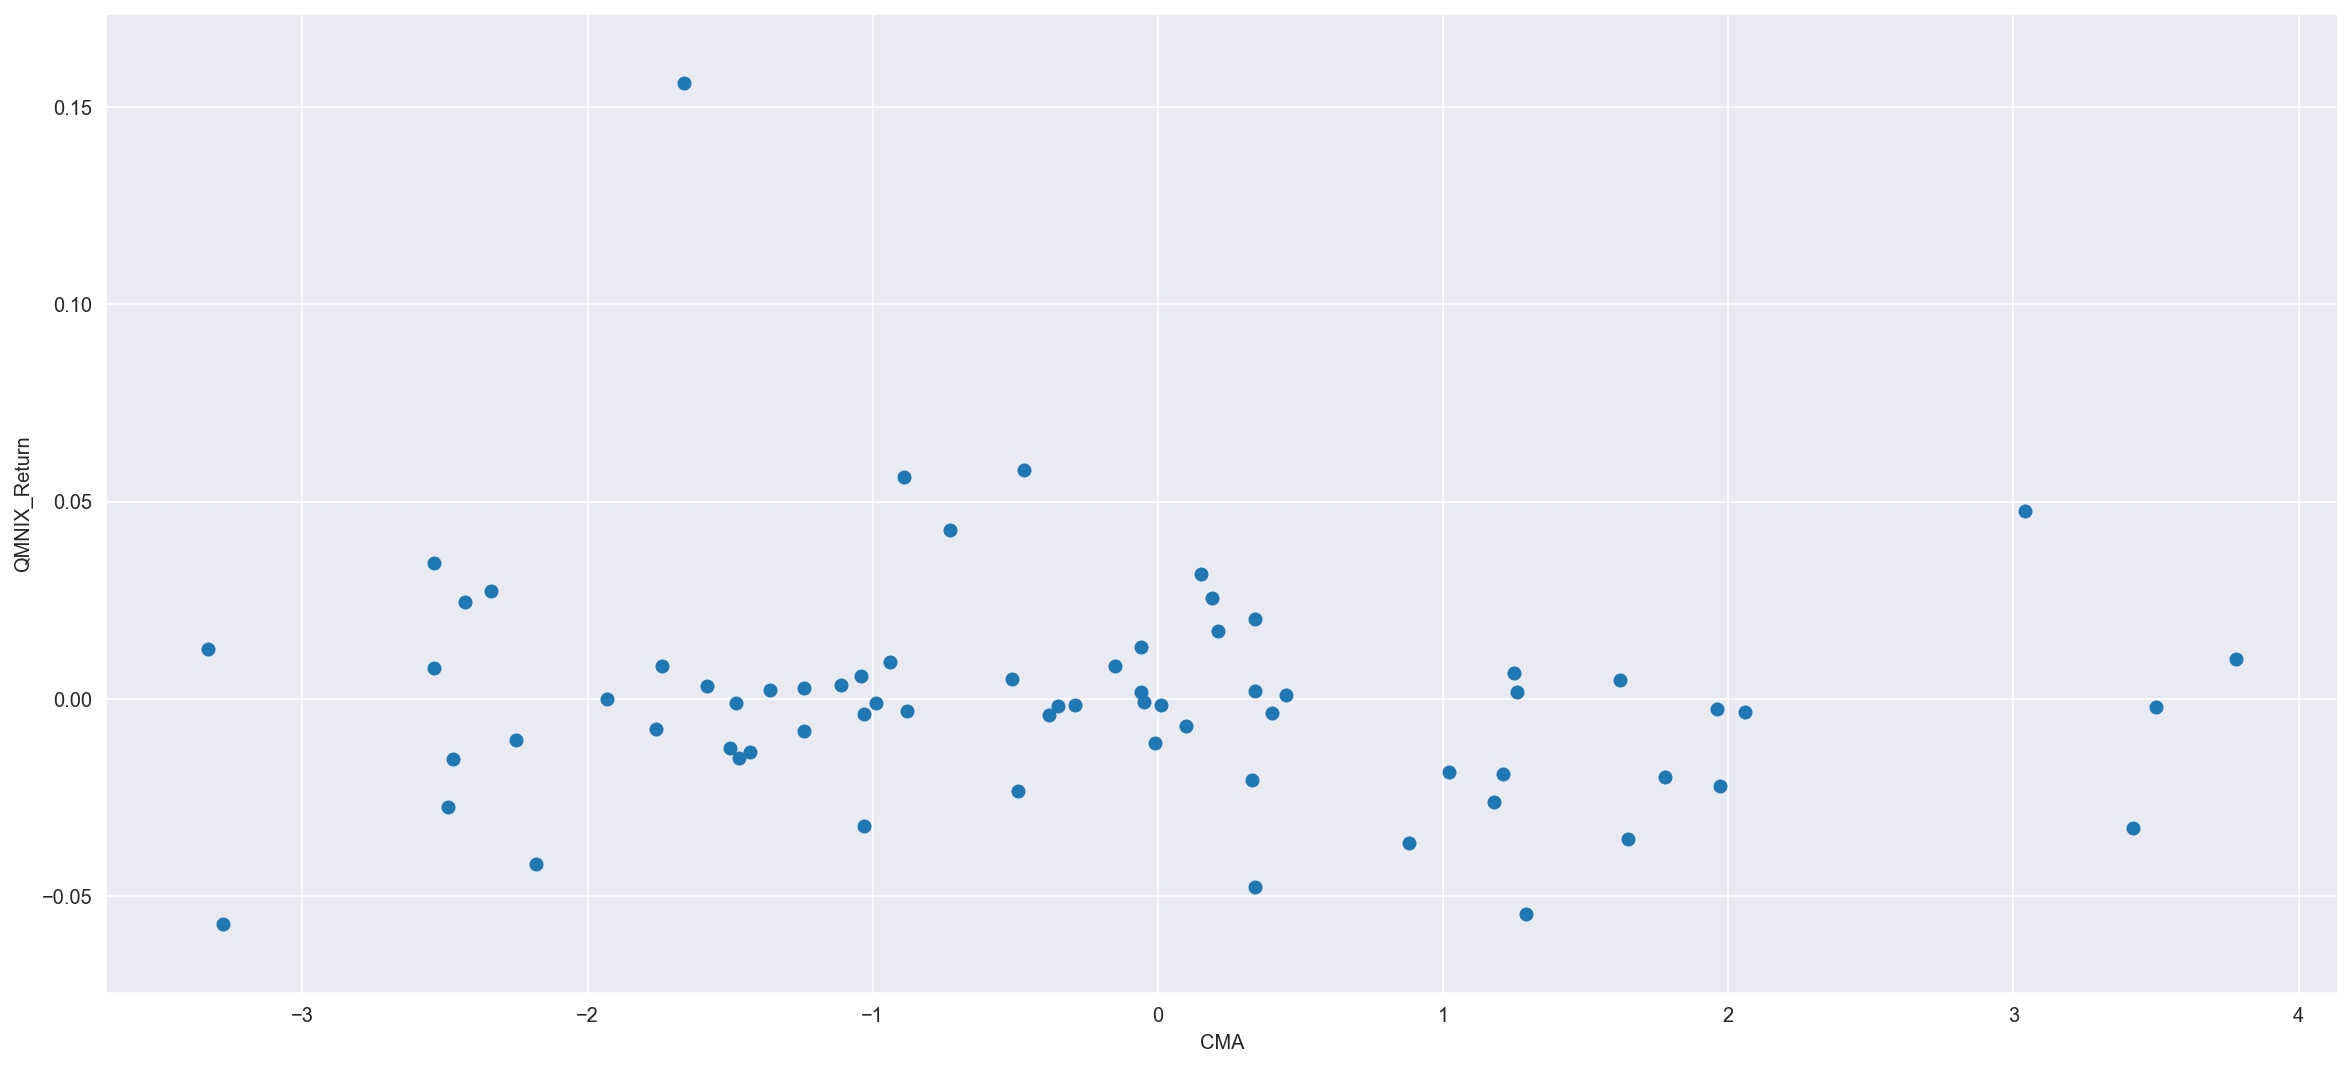

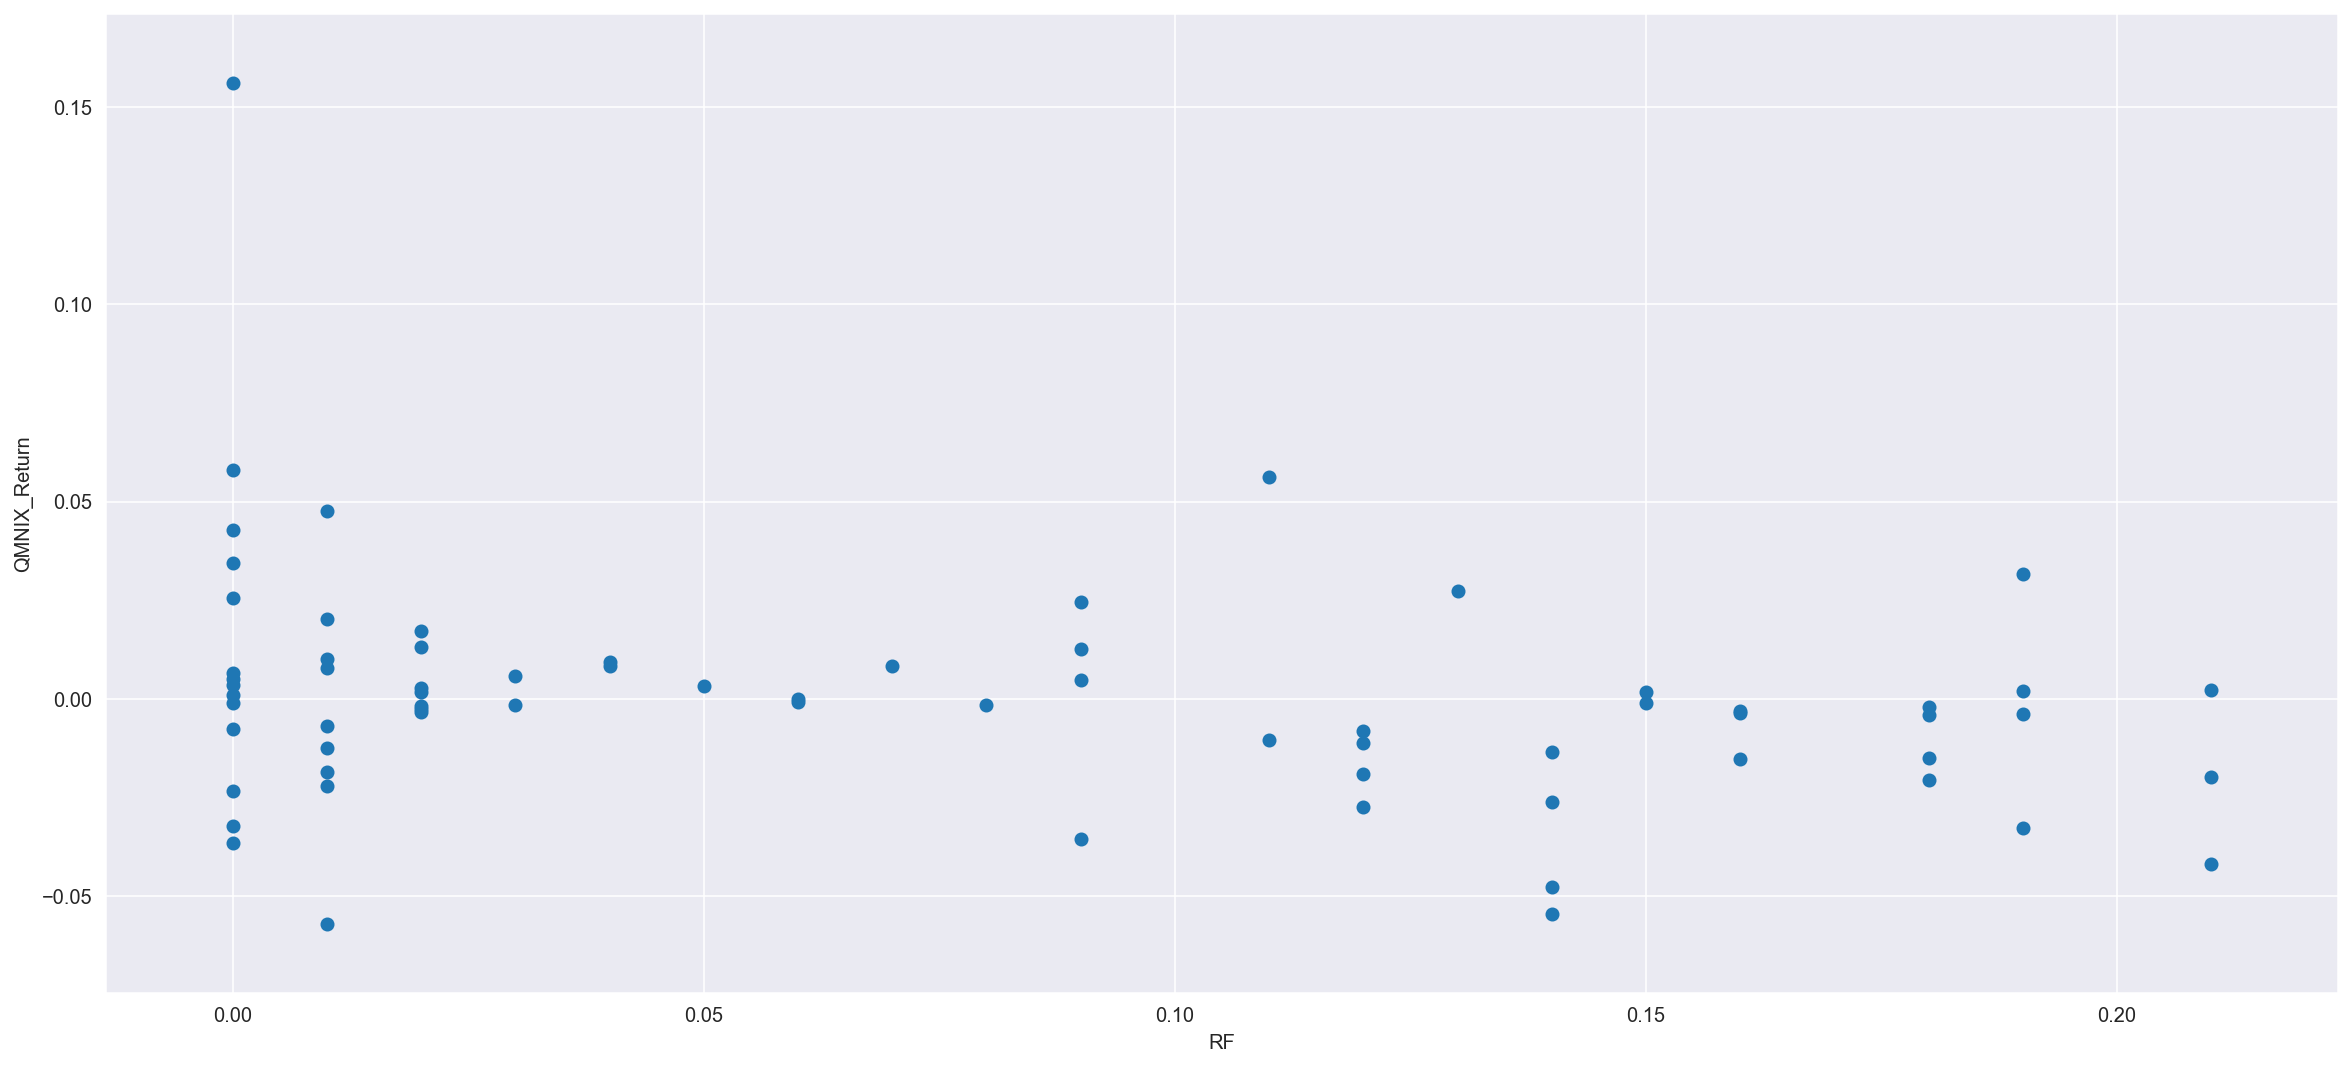

In [13]:
start = max(start_date_factors, start_date_hf)
end = min(end_date_factors, end_date_hf)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start)[:7])
print('end_date: ', str(end)[:7])
kenFrench_df_2 = kenFrench_df.loc[start:end]
QMNIX_return_df_2 = QMNIX_return_df.loc[start:end]
attributes = kenFrench_df_2.columns
for att in attributes:
    plt.scatter(kenFrench_df_2[att], QMNIX_return_df_2['Return'])
    plt.xlabel(att)
    plt.ylabel('QMNIX_Return')
    plt.show()

### (Extra credit: Perform tests for stationarity of all data series.)

### (c) Regress QMNIX on the Fama-French factors and discuss the regression results, including t- and F-tests and R2. Is the intercept statistically different from 0?

Fama-French 5 factor model:
$$ XsRet_i = a_i + b_iR_M + s_iSMB + h_iHMI + r_iRMW + c_iCMA + \epsilon_i$$

In [14]:
# prepare for all the data series
factors = kenFrench_df_2.copy()
factors['RM'] = kenFrench_df_2['RM']
factors['SMB'] = kenFrench_df_2['SMB']
factors['HML'] = kenFrench_df_2['HML']  # /100
factors['RMW'] = kenFrench_df_2['RMW']
factors['CMA'] = kenFrench_df_2['CMA']

df_stock_factor = pd.merge(QMNIX_return_df_2, factors, left_index=True, right_index=True) # Merging the stock and factor returns dataframes together
df_stock_factor['XsRet'] = df_stock_factor['Return'] - df_stock_factor['RF'] # Calculating excess returns
df_stock_factor.drop(columns = ['Return'], inplace = True)
df_stock_factor.drop(columns='RF', inplace=True)
df_stock_factor

,RM,SMB,HML,RMW,CMA,XsRet
Date,,,,,,
2014-11-01,2.55,-2.29,-2.87,1.49,0.19,0.025666
2014-12-01,-0.06,2.86,2.18,-1.16,0.88,-0.036574
2015-01-01,-3.11,-0.87,-3.50,1.67,-1.66,0.156134
2015-02-01,6.14,0.22,-1.89,-1.14,-1.76,-0.007767
2015-03-01,-1.12,3.04,-0.43,0.10,-0.51,0.004892
...,...,...,...,...,...,...
2020-04-01,13.65,2.79,-1.35,2.51,-1.03,-0.032221
2020-05-01,5.58,1.92,-4.95,0.71,-3.28,-0.067075
2020-06-01,2.46,1.94,-2.22,0.03,0.34,0.010177


In [15]:
# 5 Factors
X = df_stock_factor[df_stock_factor.columns[:-1]]
X

,RM,SMB,HML,RMW,CMA
Date,,,,,
2014-11-01,2.55,-2.29,-2.87,1.49,0.19
2014-12-01,-0.06,2.86,2.18,-1.16,0.88
2015-01-01,-3.11,-0.87,-3.50,1.67,-1.66
2015-02-01,6.14,0.22,-1.89,-1.14,-1.76
2015-03-01,-1.12,3.04,-0.43,0.10,-0.51
...,...,...,...,...,...
2020-04-01,13.65,2.79,-1.35,2.51,-1.03
2020-05-01,5.58,1.92,-4.95,0.71,-3.28
2020-06-01,2.46,1.94,-2.22,0.03,0.34


In [16]:
# Excess Returns of QMNIX Monthly
y = df_stock_factor[['XsRet']]
y

,XsRet
Date,
2014-11-01,0.025666
2014-12-01,-0.036574
2015-01-01,0.156134
2015-02-01,-0.007767
2015-03-01,0.004892
...,...
2020-04-01,-0.032221
2020-05-01,-0.067075
2020-06-01,0.010177


In [18]:
# Running FF5 model:
import statsmodels.api as sm

X = sm.add_constant(X)
FF5 = sm.OLS(y, X).fit()

In [19]:
from statsmodels.formula.api import ols
dta = df_stock_factor
formula = 'XsRet ~ RM + SMB + HML + RMW + CMA'
FF5 = ols(formula, dta).fit()

In [20]:
FF5tstat = FF5.tvalues
FF5coeff = FF5.params
FF5fitted = FF5.fittedvalues
FF5resid = FF5.resid
FF5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  XsRet   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.4812
Date:                Tue, 06 Oct 2020   Prob (F-statistic):              0.789
Time:                        13:42:10   Log-Likelihood:                 74.576
No. Observations:                  70   AIC:                            -137.2
Df Residuals:                      64   BIC:                            -123.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0761      0.011     -6.733      0.000      -0.099      -0.054
RM            -0.0007      0.003     -0.232      0.817      -0.006       0.005
SMB            0.0025      0.005      0.518      0.606      -0.007       0.012
HML            0.0028      0.004      0.626      0.534      -0.006       0.012
RMW            0.0080      0.008      1.030      0.307      -0.008       0.024
CMA           -0.0081      0.008     -0.976      0.333      -0.025       0.008
==============================================================================
Omnibus:                        1.735   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                1.442
Skew:                          -0.185   Prob(JB):                        0.486
Kurtosis:                       2.402   Cond. No.                         5.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### (d) Demonstrate graphically whether the classical linear regression assumptions are satisfied or not in (c).
- Linearity
$$ y = X\beta + \epsilon $$
- Strict Exogeneity
$$ \mathbf{E}[\epsilon | X ] = 0$$
- No Multicollinearity
$$ \mathbf{P}[rank(X) = p] = 1 $$
- Spherical Errors
$$ var[\epsilon|X] = \sigma^2I_n$$

In [21]:
# Linearity: 
# nonlinearity is usually most evident in a plot of observed versus predicted values 
# or a plot of residuals versus predicted values, which are a part of standard regression output.
# The points should be symmetrically distributed around a diagonal line in the former plot or 
# around horizontal line in the latter plot, with a roughly constant variance.  
# (The residual-versus-predicted-plot is better than the observed-versus-predicted plot for 
# this purpose, because it eliminates the visual distraction of a sloping pattern.)  
# Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic 
# errors whenever it is making unusually large or small predictions. In multiple regression 
# models, nonlinearity or nonadditivity may also be revealed by systematic patterns in plots 
# of the residuals versus individual independent variables.

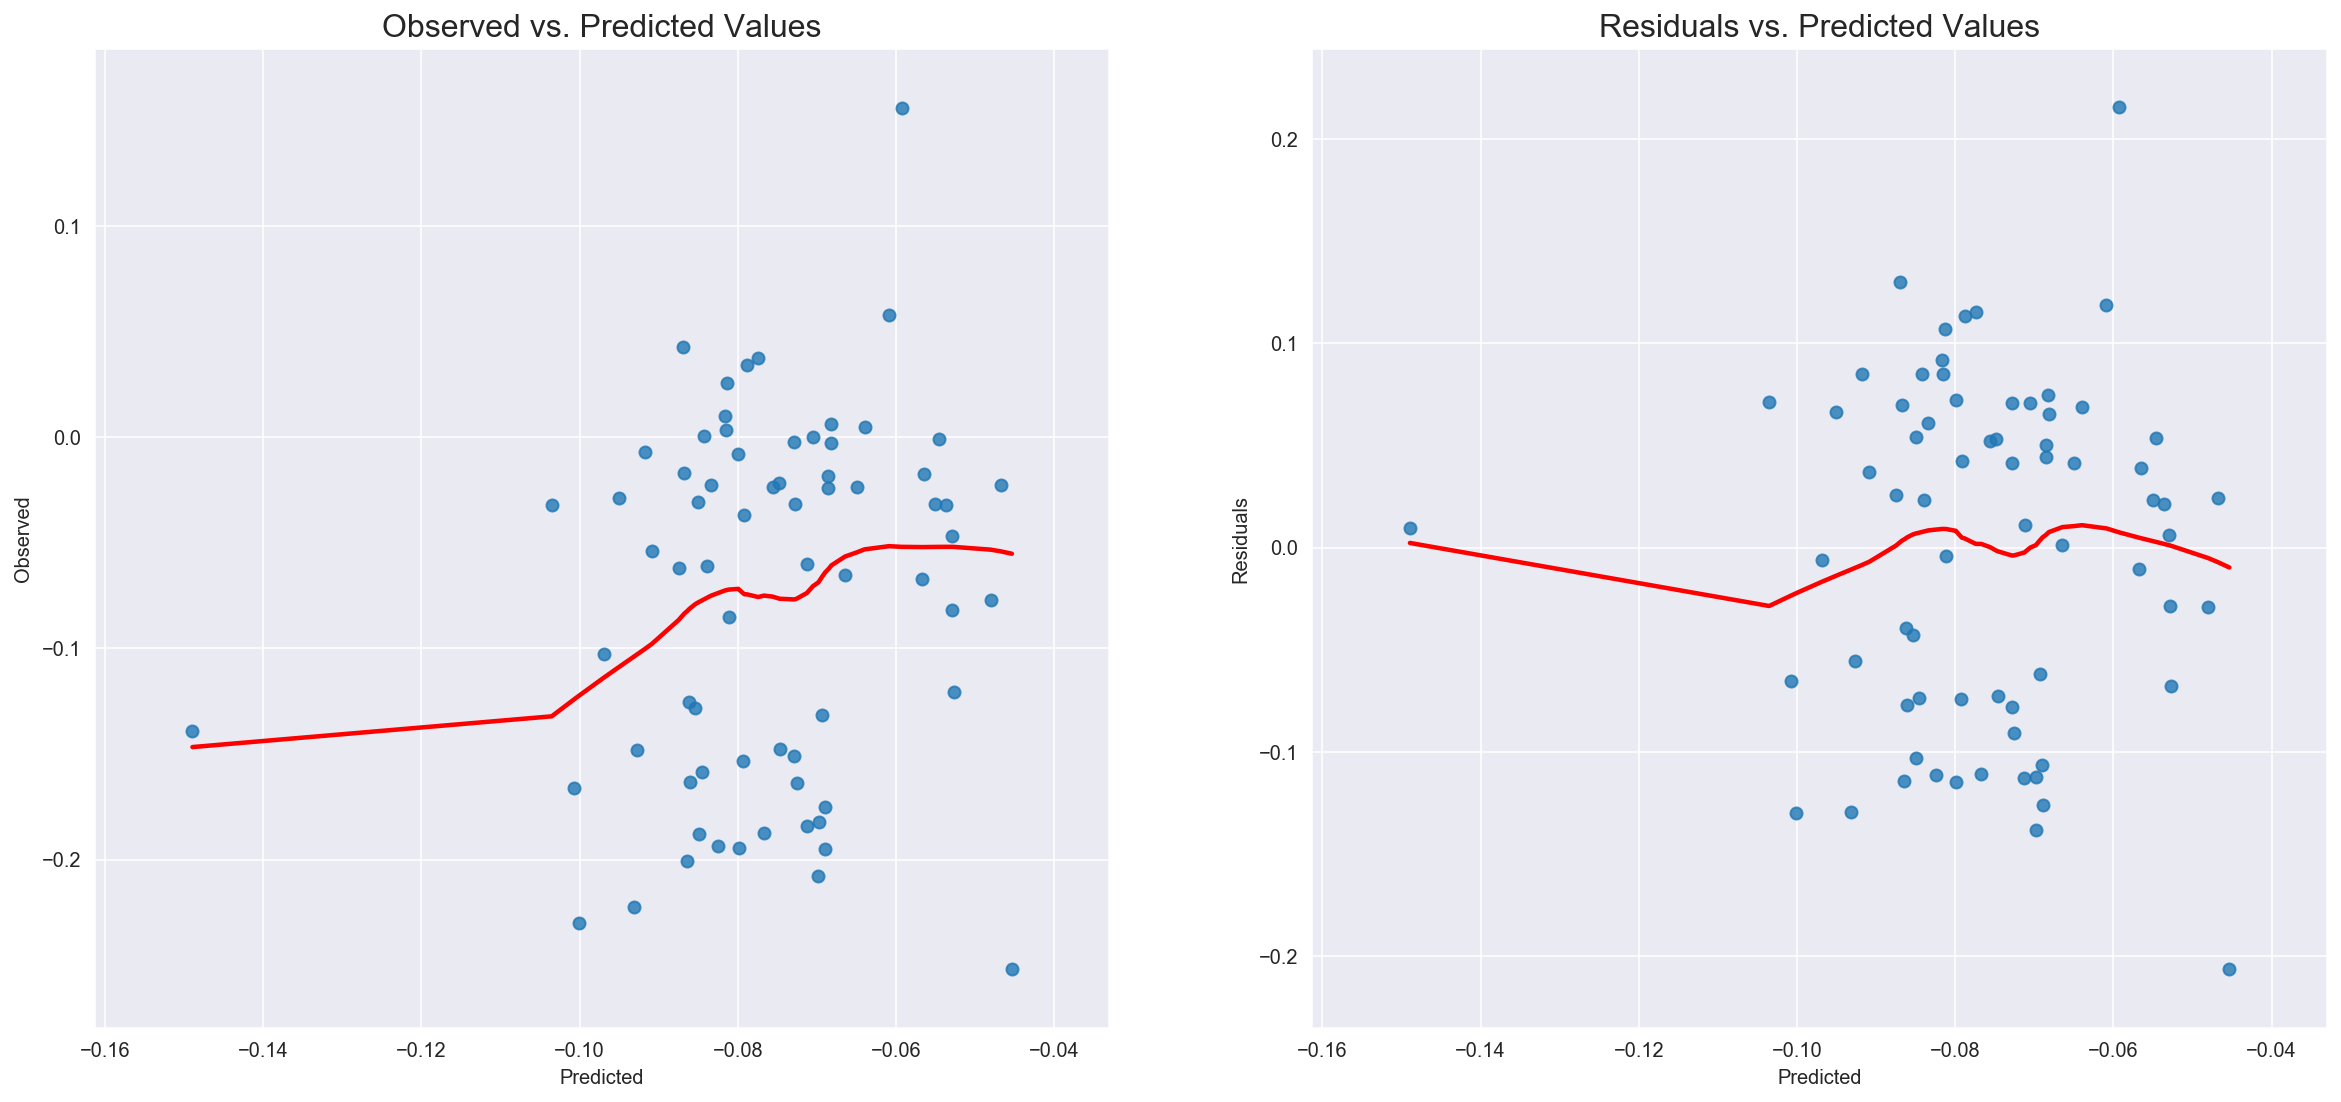

In [22]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.fittedvalues
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(FF5, y)    

mean of residuals =  -3.162153079066294e-17


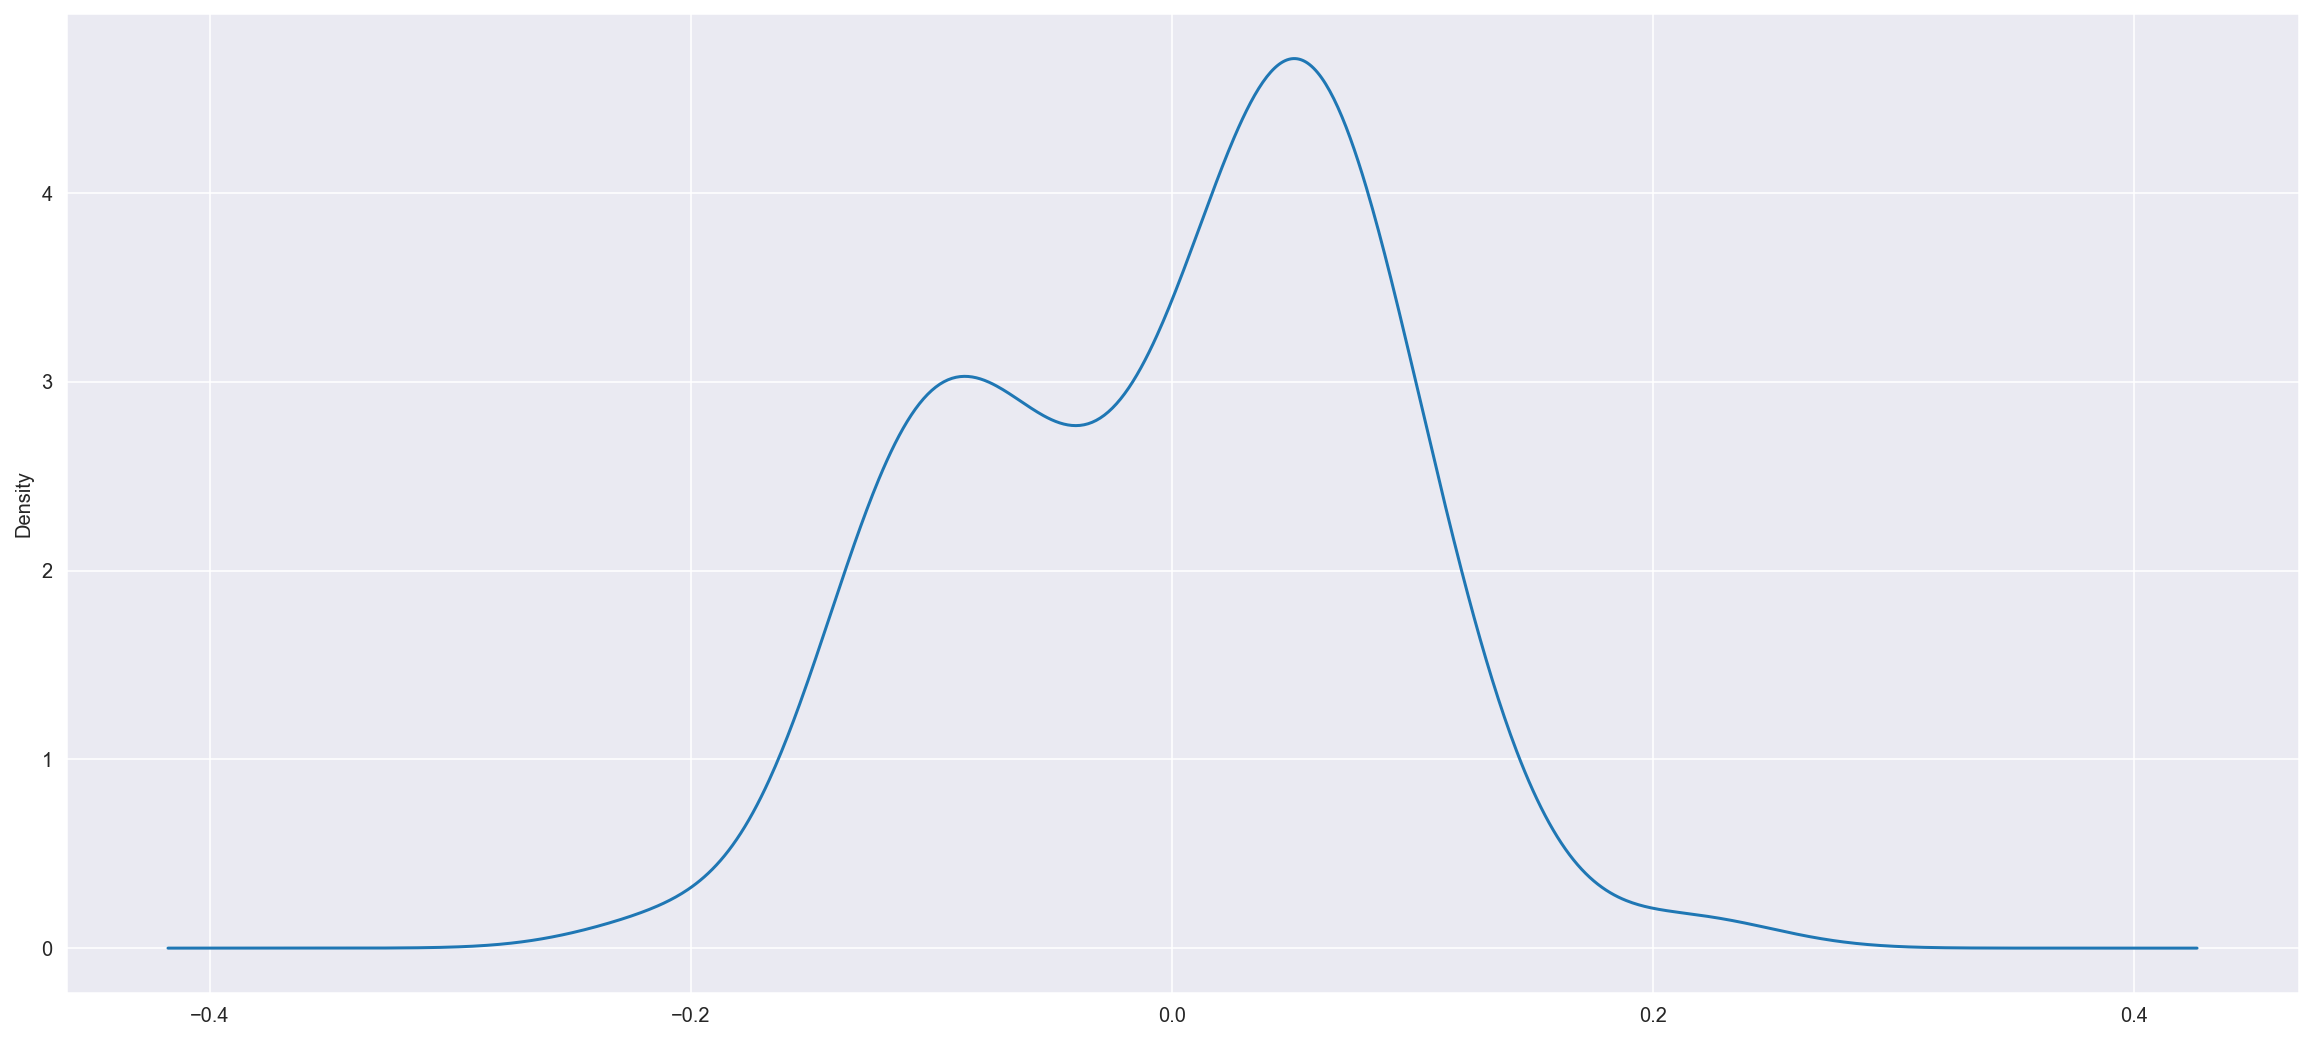

In [23]:
# strict exogeneity
# the distribution of error terms has zero mean 
# and doesn’t depend on the independent variables X
# Thus, there must be no relationship between the X and the error term.
print('mean of residuals = ', FF5resid.mean())
FF5resid.plot(kind='kde')
plt.show()

In [25]:
df = factors.copy()
df['residuals'] = FF5resid
df.corr()[['residuals']]

,residuals
RM,2.751168e-17
SMB,1.267592e-16
HML,6.465375e-17
RMW,-1.365030e-16
CMA,-1.991819e-16
RF,-9.228418e-01
residuals,1.000000e+00


In [26]:
# No Multicollinearity
# Looking at bivariate correlation. >0.8 is an indicator of multicollinearity
factors.corr()

,RM,SMB,HML,RMW,CMA,RF
RM,1.000000,0.385212,0.184156,0.152294,-0.243935,-0.145260
SMB,0.385212,1.000000,0.400354,-0.210908,0.031821,-0.162134
HML,0.184156,0.400354,1.000000,0.066140,0.504206,-0.096495
RMW,0.152294,-0.210908,0.066140,1.000000,0.080734,-0.088743
CMA,-0.243935,0.031821,0.504206,0.080734,1.000000,0.045249
RF,-0.145260,-0.162134,-0.096495,-0.088743,0.045249,1.000000


In [27]:
# Here are seven more indicators of multicollinearity.
'''
1. Very high standard errors for regression coefficients
When standard errors are orders of magnitude higher than their coefficients, that’s an indicator.

2. The overall model is significant, but none of the coefficients are
Remember that a p-value for a coefficient tests whether the unique effect of that predictor on Y
is zero. If all predictors overlap in what they measure, there is little unique effect, even if 
the predictors as a group have an effect on Y.

3. Large changes in coefficients when adding predictors
If the predictors are completely independent of each other, their coefficients won’t change at 
all when you add or remove one. But the more they overlap, the more drastically their 
coefficients will change.

4. Coefficients have signs opposite what you’d expect from theory
Be careful here as you don’t want to disregard an unexpected finding as problematic. Not all 
effects opposite theory indicate a problem with the model. That said, it could be 
multicollinearity and warrants taking a second look at other indicators.

5. Coefficients on different samples are wildly different
If you have a large enough sample, split the sample in half and run the model separately on 
each half. Wildly different coefficients in the two models could be a sign of multicollinearity.

6. High Variance Inflation Factor (VIF) and Low Tolerance
These two useful statistics are reciprocals of each other. So either a high VIF or a low 
tolerance is indicative of multicollinearity. VIF is a direct measure of how much the variance 
of the coefficient (ie. its standard error) is being inflated due to multicollinearity.

7. High Condition Indices
Condition indices are a bit strange.  The basic idea is to run a Principal Components Analysis 
on all predictors. If they have a lot of shared information, the first Principal Component 
will be much higher than the last. Their ratio, the Condition Index, will be high if 
multicollinearity is present.
'''
pass

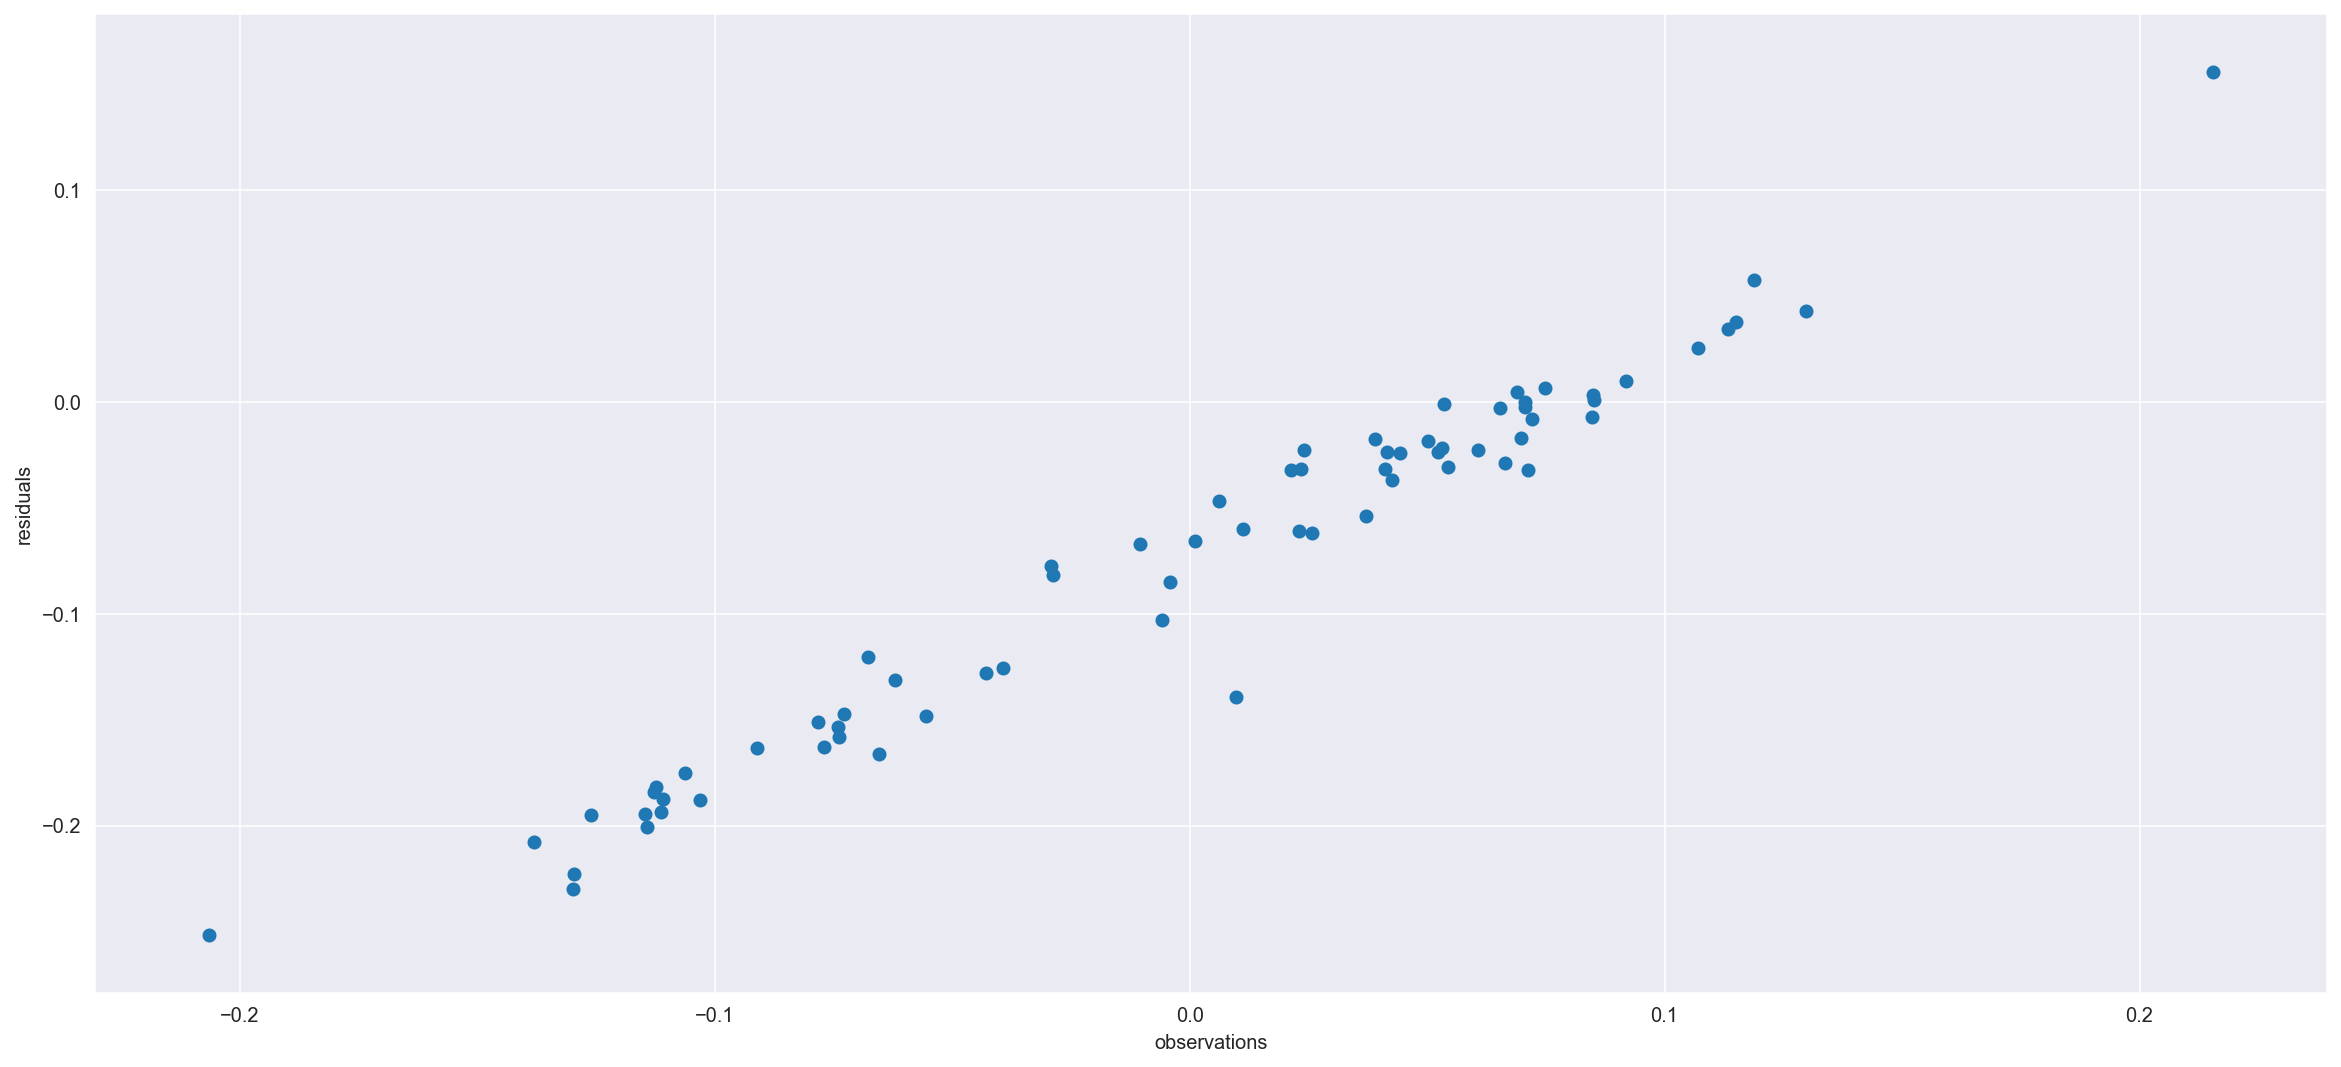

In [28]:
# spherical error variance
# There is homoscedasticity and no autocorrelation.
# the error terms in the regression should all have the same variance, not depend on Xs.
# the error terms of different observations should not be correlated with each other, 
# i.e.error terms should be IID (Independent and Identically Distributed).

plt.scatter(FF5resid, y)
plt.ylabel('residuals')
plt.xlabel('observations')
plt.show()

### (e) Provide a financial/economic interpretation of your results from (c).

### (f) Extra credit: Download and import the monthly data of the 10 Industry Portfolios model from Ken French’s data library. The 10 Industry Portfolios model is described here. Then perform the analysis (c)-(e) using this data.

### (g) Extra credit: Download and import the daily data of all the data series. Make sure you use the same time period as above. You will find them on Ken French’s website and Yahoo Finance. Then perform the same analysis as above. Are the classical linear regression assumptions satisfied for the regressions with daily data? Does your analysis using daily data provide different results compared to the analysis based on monthly data? Why, or why not?

## Q2: Linear regression models for the housing dataset.
In this question you will be extending the Jupyter notebook ``lec04_skl_ols_workflow_housing_data.ipynb`` used during the last lecture:

In [29]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    if not os.path.isfile(tgz_path): #download data if not already there
        urllib.request.urlretrieve(housing_url, tgz_path)
        
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [30]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [31]:
# to make this notebook's output identical at every run
np.random.seed(42)
import numpy as np

# One way to do it
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

# a 'fancy' way of doing split train-test
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

# This version supports both Python 2 and Python 3, instead of just Python 3.
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

16512 train + 4128 test


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [32]:
# or we can use 1000 * longitude + latitude as an index, so that we sample according to geography
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [34]:
from sklearn.model_selection import train_test_split

# this correspond to random of the data
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [35]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [37]:
# Let's verify....
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [38]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [39]:
housing = strat_train_set.copy() 
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
# rooms per household might be more meaningful 
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

# likewise bedrooms per room
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

# or population per household
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [40]:
# ML
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows.dropna(subset=["total_bedrooms"])
sample_incomplete_rows.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

# Fortunately sklearn has an Imputer class that does all this too
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [41]:
# All estimators have learned parameters which are usually with underscore suffixed variables
# Below, the imputer learned parameters are accessible through statistics_ variable which is just the median
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [42]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))
print(housing_tr.loc[sample_incomplete_rows.index.values])
print(imputer.strategy)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income  
4629       3296.0      1462.0         2.2708  
6068       3038.0       727.0         5.1762  
17923       999.0       386.0         4.6328  
13656      1039.0       391.0         1.6675  
19252      3468.0      1405.0         3.1662  
median


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [43]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot #note that the output is a sparse matrix
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [44]:
# Let's create our own transformer which transformes all our numerical variables
# Note that the BaseEstimator is the abstract class we need to always inherit from. 
# The TransformerMixin class basically adds the fit_transform() method once the fit() 
# and transform() methods are implemented
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [45]:
# One nice thing about Transformers is they can be pipelined. 
# A Pipeline is a transformer whose transform() method calls teh transform() 
# methods of each component:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()), # a stransformer which scales the variables 
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# LabelBinarizer is same as OneHotEncoder but fit_transform() equivalent to fit_transform().to_array() of OneHotEncoder
# unfortunately LabelBinarizer isn't pipeline friendly so we'll have to extend it as below:
from sklearn.preprocessing import LabelBinarizer 
class PipelineFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(PipelineFriendlyLabelBinarizer, self).fit_transform(X)
    
ppflb = PipelineFriendlyLabelBinarizer()
housing_cat_1hot_lb = ppflb.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot_lb

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [46]:
# let's now combine the numerical and categorical pipelines
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', PipelineFriendlyLabelBinarizer()),
    ])
# and concatenate them with FeatureUnion class
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
# this is the final transformation result!
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [47]:
# Select and train an OLS model 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [48]:
# A full pipeline with both preparation and prediction
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

### (a) Implement a LinRegStatsmodels() Predictor Class that uses the OLS statsmodels class and its .fit() and .predict() methods. Whenever you call .fit() to an instance A of your class, the statsmodels results should be recorded in an attribute A.results.

In [49]:
import statsmodels.api as sm
class LinRegStatsmodels(object):
    def __init__(self, heteroskedastic = False):
        
        self.heteroskedastic = heteroskedastic
        self.model = None
        
        self.fitted = False
        self.results = None
        self.summary = False
        
        self.predicted = None
        
    def fit(self, X, y, 
            method = 'pinv', 
            add_constant = False, missing = 'none'):
        '''
        heteroskedastic: bool
            False: 'nonrobust' default without heteroskedastic standard errors
            True: 'HC0','HC1','HC2','HC3' heteroscedasticity robust covariance
        method: str
            'qr': QR factorization 
            'pinv': default, Moore-Penrose pseudoinverse to solve the least squares problem
        
        add_constant: default is False. True if need to add one column of ones to parameters
        missing: dealing with NaN
        '''
        
        self.y = y
        
        if add_constant:
            self.X = sm.add_constant(X)
        else:
            self.X = X
        
        model = sm.OLS(self.y, self.X, missing = missing)
        
        heteroskedastic = self.heteroskedastic
        
        if not heteroskedastic:
            self.results = model.fit(method = method, cov_type = 'nonrobust')
        else:
            self.results = model.fit(method = method, cov_type = 'HC0')
            
        self.fitted = True
        self.summary = self.results.summary()
        print(self.summary)
    
    def predict(self, exog = None):
        if not self.fitted:
            raise RuntimeError('Model has not been fitted!')
        else:
            self.predicted = self.results.predict(exog = exog)
        return self.predicted
        
    def get_summary(self):
        if not self.summary:
            raise RuntimeError('Model has not been fitted!')
        else:
            return self.summary

### (b) In the full_pipeline_with_predictor in the Jypyter notebook above, substitute your LinRegStatsmodels() class and then compute the summary statistics of your regression using both OLS and OLS with heteroskedastic standard errors.

In [50]:
# OLS without hse
full_pipeline_with_predictor_2 = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinRegStatsmodels(heteroskedastic = False))
    ])

full_pipeline_with_predictor_2.fit(housing, housing_labels)
full_pipeline_with_predictor_2.predict(some_data)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2026.
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:42:49   Log-Likelihood:            -2.0731e+05
No. Observations:               16512   AIC:                         4.147e+05
Df Residuals:                   16496   BIC:                         4.148e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -5.565e+04   2292.900    -24.271      0.0

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849878])

In [51]:
# OLS with hse
full_pipeline_with_predictor_2 = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinRegStatsmodels(heteroskedastic = True))
    ])

full_pipeline_with_predictor_2.fit(housing, housing_labels)
full_pipeline_with_predictor_2.predict(some_data)

C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 06 Oct 2020   Prob (F-statistic):                nan
Time:                        13:42:50   Log-Likelihood:            -2.0731e+05
No. Observations:               16512   AIC:                         4.147e+05
Df Residuals:                   16496   BIC:                         4.148e+05
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -5.565e+04   2334.905    -23.834      0.0

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849878])

### (c) Interpret your regressions results. What can you say about the models?